## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


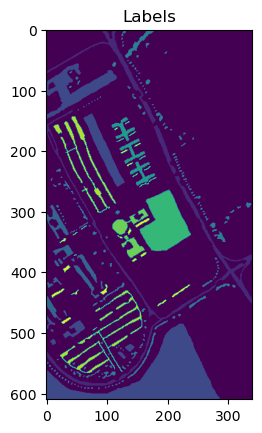

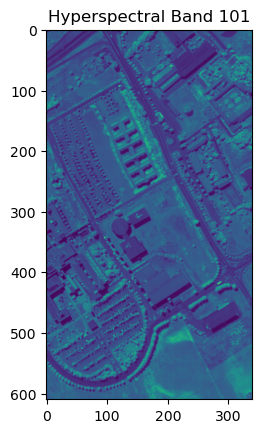

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 10 train


All datasets saved to the 'indices' folder.
(90, 5, 5, 103)
(45, 5, 5, 103)
(42641, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1160, PSNR: 7.5593


	 Training Batch [200/535], Loss: 0.0600, PSNR: 10.3386


	 Training Batch [400/535], Loss: 0.0302, PSNR: 13.1274


Epoch [1/50] Training Loss: 0.0547, PSNR: 11.2583
	[Val]   Batch [1/134] Loss: 0.0189, PSNR: 15.4268
	[Val]   Batch [10/134] Loss: 0.0166, PSNR: 17.7861
	[Val]   Batch [20/134] Loss: 0.0179, PSNR: 15.5874
	[Val]   Batch [30/134] Loss: 0.0194, PSNR: 15.0571
	[Val]   Batch [40/134] Loss: 0.0176, PSNR: 14.0814
	[Val]   Batch [50/134] Loss: 0.0187, PSNR: 15.2606
	[Val]   Batch [60/134] Loss: 0.0170, PSNR: 15.8947


	[Val]   Batch [70/134] Loss: 0.0161, PSNR: 16.1025
	[Val]   Batch [80/134] Loss: 0.0158, PSNR: 16.0920
	[Val]   Batch [90/134] Loss: 0.0165, PSNR: 16.0904
	[Val]   Batch [100/134] Loss: 0.0187, PSNR: 15.4833
	[Val]   Batch [110/134] Loss: 0.0190, PSNR: 14.0263
	[Val]   Batch [120/134] Loss: 0.0156, PSNR: 15.1788
	[Val]   Batch [130/134] Loss: 0.0172, PSNR: 13.2074
Epoch [1/50] Validation Loss: 0.0179, PSNR: 15.4473

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0186, PSNR: 15.5396


	 Training Batch [200/535], Loss: 0.0118, PSNR: 17.5559


	 Training Batch [400/535], Loss: 0.0103, PSNR: 18.0098


Epoch [2/50] Training Loss: 0.0116, PSNR: 17.5097
	[Val]   Batch [1/134] Loss: 0.0086, PSNR: 18.8542
	[Val]   Batch [10/134] Loss: 0.0069, PSNR: 21.6269
	[Val]   Batch [20/134] Loss: 0.0074, PSNR: 19.3870
	[Val]   Batch [30/134] Loss: 0.0085, PSNR: 18.6495
	[Val]   Batch [40/134] Loss: 0.0076, PSNR: 17.7418
	[Val]   Batch [50/134] Loss: 0.0079, PSNR: 19.0002


	[Val]   Batch [60/134] Loss: 0.0069, PSNR: 19.8116
	[Val]   Batch [70/134] Loss: 0.0067, PSNR: 19.9148
	[Val]   Batch [80/134] Loss: 0.0064, PSNR: 19.9908
	[Val]   Batch [90/134] Loss: 0.0068, PSNR: 19.9333
	[Val]   Batch [100/134] Loss: 0.0082, PSNR: 19.0892
	[Val]   Batch [110/134] Loss: 0.0077, PSNR: 17.9324
	[Val]   Batch [120/134] Loss: 0.0057, PSNR: 19.5174
	[Val]   Batch [130/134] Loss: 0.0069, PSNR: 17.1400
Epoch [2/50] Validation Loss: 0.0077, PSNR: 19.1148

LOG: Epoch [3/50]


	 Training Batch [1/535], Loss: 0.0070, PSNR: 19.6760


	 Training Batch [200/535], Loss: 0.0063, PSNR: 18.6649


	 Training Batch [400/535], Loss: 0.0077, PSNR: 20.6537


Epoch [3/50] Training Loss: 0.0067, PSNR: 19.7440
	[Val]   Batch [1/134] Loss: 0.0058, PSNR: 20.5244
	[Val]   Batch [10/134] Loss: 0.0046, PSNR: 23.3483
	[Val]   Batch [20/134] Loss: 0.0049, PSNR: 21.1916
	[Val]   Batch [30/134] Loss: 0.0056, PSNR: 20.4788
	[Val]   Batch [40/134] Loss: 0.0051, PSNR: 19.4812
	[Val]   Batch [50/134] Loss: 0.0052, PSNR: 20.8505
	[Val]   Batch [60/134] Loss: 0.0045, PSNR: 21.6288


	[Val]   Batch [70/134] Loss: 0.0045, PSNR: 21.6563
	[Val]   Batch [80/134] Loss: 0.0043, PSNR: 21.7749
	[Val]   Batch [90/134] Loss: 0.0045, PSNR: 21.7002
	[Val]   Batch [100/134] Loss: 0.0055, PSNR: 20.8144
	[Val]   Batch [110/134] Loss: 0.0049, PSNR: 19.8858
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5861
	[Val]   Batch [130/134] Loss: 0.0044, PSNR: 19.0831
Epoch [3/50] Validation Loss: 0.0052, PSNR: 20.8438

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0070, PSNR: 19.8341


	 Training Batch [200/535], Loss: 0.0060, PSNR: 20.4550


	 Training Batch [400/535], Loss: 0.0046, PSNR: 21.3760


Epoch [4/50] Training Loss: 0.0047, PSNR: 21.3097
	[Val]   Batch [1/134] Loss: 0.0040, PSNR: 22.1476
	[Val]   Batch [10/134] Loss: 0.0032, PSNR: 24.9454
	[Val]   Batch [20/134] Loss: 0.0032, PSNR: 23.0189
	[Val]   Batch [30/134] Loss: 0.0036, PSNR: 22.3321
	[Val]   Batch [40/134] Loss: 0.0033, PSNR: 21.3024
	[Val]   Batch [50/134] Loss: 0.0033, PSNR: 22.8351
	[Val]   Batch [60/134] Loss: 0.0032, PSNR: 23.1560


	[Val]   Batch [70/134] Loss: 0.0031, PSNR: 23.2665
	[Val]   Batch [80/134] Loss: 0.0029, PSNR: 23.3967
	[Val]   Batch [90/134] Loss: 0.0031, PSNR: 23.3368
	[Val]   Batch [100/134] Loss: 0.0037, PSNR: 22.5129
	[Val]   Batch [110/134] Loss: 0.0031, PSNR: 21.8748
	[Val]   Batch [120/134] Loss: 0.0023, PSNR: 23.4446
	[Val]   Batch [130/134] Loss: 0.0028, PSNR: 21.0131
Epoch [4/50] Validation Loss: 0.0036, PSNR: 22.5197

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 21.1138


	 Training Batch [200/535], Loss: 0.0040, PSNR: 22.2006


	 Training Batch [400/535], Loss: 0.0032, PSNR: 23.0886


Epoch [5/50] Training Loss: 0.0035, PSNR: 22.6484
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.3437
	[Val]   Batch [10/134] Loss: 0.0024, PSNR: 26.1587
	[Val]   Batch [20/134] Loss: 0.0023, PSNR: 24.5104
	[Val]   Batch [30/134] Loss: 0.0026, PSNR: 23.7743
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.7770
	[Val]   Batch [50/134] Loss: 0.0023, PSNR: 24.3810
	[Val]   Batch [60/134] Loss: 0.0025, PSNR: 24.2732


	[Val]   Batch [70/134] Loss: 0.0024, PSNR: 24.4398
	[Val]   Batch [80/134] Loss: 0.0022, PSNR: 24.5766
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.4936
	[Val]   Batch [100/134] Loss: 0.0027, PSNR: 23.8391
	[Val]   Batch [110/134] Loss: 0.0021, PSNR: 23.5338
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.8956
	[Val]   Batch [130/134] Loss: 0.0020, PSNR: 22.4676
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.8057

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0037, PSNR: 22.5739


	 Training Batch [200/535], Loss: 0.0030, PSNR: 23.4169


	 Training Batch [400/535], Loss: 0.0029, PSNR: 23.7232


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.5393
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.0008
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.8934
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.4280
	[Val]   Batch [30/134] Loss: 0.0021, PSNR: 24.6050
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.6663
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2441
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9595


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1569
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3104
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.1738
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.6222
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.4999
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.8209
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3039
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.5761

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 23.1812


	 Training Batch [200/535], Loss: 0.0022, PSNR: 22.7329


	 Training Batch [400/535], Loss: 0.0036, PSNR: 22.6539


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1509
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5228
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4702
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1787
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.2800
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.4008
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9741
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.5095


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.7226
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 25.9046
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7032
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2633
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3127
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5642
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 23.9708
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2024

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0030, PSNR: 25.2358


	 Training Batch [200/535], Loss: 0.0026, PSNR: 24.0978


	 Training Batch [400/535], Loss: 0.0026, PSNR: 24.1587


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5677
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9313
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.8856
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7890
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.8107
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0009
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.5131
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.9273


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1588
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3659
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1094
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7533
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9826
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.1240
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4863


Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.6943

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 25.1777


	 Training Batch [200/535], Loss: 0.0015, PSNR: 25.0880


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.6090


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9493
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2370
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1732
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.1855
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.1541
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3954
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8539
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2350


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4289
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6787
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.3912
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.0723
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4037
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5201
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.8334
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.0303

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0176


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.5790


	 Training Batch [400/535], Loss: 0.0018, PSNR: 27.5547


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2167
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.5220
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4748
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6064
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5186
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.7876
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1834


	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5651
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7380
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0247
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.6990
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4109
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8386


	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9588
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1965
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3795

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0015


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.6813


	 Training Batch [400/535], Loss: 0.0022, PSNR: 26.6203


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4164
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.7428
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.6971
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9689
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8216
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.1237
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4922
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8514


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0349
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2822
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9547
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7092
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1862
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2627
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5230


Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6716

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 25.7088


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.3891


	 Training Batch [400/535], Loss: 0.0014, PSNR: 25.1272


Epoch [12/50] Training Loss: 0.0017, PSNR: 25.6710
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 26.0047
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9741
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.3184
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1487
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4293
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8140
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1266


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2731
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5965
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2440
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9897
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5765
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6172
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8130
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9699

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.5245


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.1722


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.2573


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8497
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1282
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0995
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.5320
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.3074
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6102
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9440
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3200


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4489
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7608
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3956
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1586
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6814
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7514
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0006
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.1342

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.3570


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.8318


	 Training Batch [400/535], Loss: 0.0016, PSNR: 27.8370


Epoch [14/50] Training Loss: 0.0016, PSNR: 26.0359
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3506
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2854
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8720
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5904
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.9178
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2254
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6063


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7250
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0131
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.6690
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4114
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 28.0168
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0197
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3311


Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.4062

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.9677


	 Training Batch [200/535], Loss: 0.0013, PSNR: 28.8470


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2421


Epoch [15/50] Training Loss: 0.0015, PSNR: 26.2142
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5625
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5091
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1918
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8468
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1816
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4496
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8742


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 27.9666
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.2957
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9133
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6602
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2163
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2171
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5698


Epoch [15/50] Validation Loss: 0.0011, PSNR: 27.6487

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.2503


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.8830


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.8686


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3765
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7732
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6604
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4379
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0650
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.3774
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6501
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1160


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2093
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5184
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1475
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8577
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3453
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3872
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7762
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.8512

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1782


	 Training Batch [200/535], Loss: 0.0012, PSNR: 25.7989


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.4444


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.6009
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0688
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9162
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8179
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4234
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7825
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9913


	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4680
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5670
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8491
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4597
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2120
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7242
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6720


	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1407
Epoch [17/50] Validation Loss: 0.0010, PSNR: 28.1830

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 25.6612


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.0516


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.5685


Epoch [18/50] Training Loss: 0.0013, PSNR: 26.7884
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.2094
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0216
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0184
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5753
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.9231
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1262
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6738


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7651
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0206
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6713
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3842
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7354
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7131
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2703
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.3363

LOG: Epoch [19/50]


	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.9466


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.2129


	 Training Batch [400/535], Loss: 0.0010, PSNR: 27.9447


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.9102
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.5161
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2492
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4160
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.9509
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2872
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4861


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0298
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.0939
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3436
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.0050
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7395
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0591
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9529


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6316
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.6618

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.5453


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.2192


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.6757


Epoch [20/50] Training Loss: 0.0012, PSNR: 27.0908
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7914
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4433
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.5630
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.1914
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4621
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6839
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.2659


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3779
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6179
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2809
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9519
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1605
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1416
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7651


Epoch [20/50] Validation Loss: 0.0008, PSNR: 28.8770

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 27.1450


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.8829


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.2274


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.3216
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0172
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6200
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7945
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4522
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6767
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.9024
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.4668


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.6142
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8294
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5515
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1856
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2791
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1922
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9871
Epoch [21/50] Validation Loss: 0.0008, PSNR: 29.0903

LOG: Epoch [22/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9072


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.5858


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4882


Epoch [22/50] Training Loss: 0.0011, PSNR: 27.4754
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2440
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8032
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9999
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7016
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9101
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1612
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6929


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.8588
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0082
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7714
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4535
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4406
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3413
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1972
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.3246

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.4740


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8216


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.8855


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.6124
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.3873
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8964
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0800
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8100
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9042
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2257
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.7707


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9039
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0982
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.9438
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.5952
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3854
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2344
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1797
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.4199

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.4992


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.0034


	 Training Batch [400/535], Loss: 0.0008, PSNR: 26.9844


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.8374
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8432
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.2711
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6140
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3567
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4115
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7433


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1881
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3850
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5310
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4221
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0377
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8755
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6877


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6705
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.8779

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.4317


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.3127


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.3378


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9233
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9819
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3843
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6448
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4444
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4263
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7966
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2756


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5076
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6169
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5422
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1432
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8337
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6795
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6369


Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9612

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.2924


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.0202


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.6469


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0731
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2868
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6155
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.9152
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8135
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6427
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1220


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5236
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7713
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8572
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8555
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.4329
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1190
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9251
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9006


Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.2539

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.0359


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.1086


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.2773


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2097
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.5023
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7755
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0932
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9733
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7478
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.2877
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.6613


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.9242
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0271
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.0474
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5823
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.2360
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9765
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 29.0050
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.4160

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.5410


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.6164


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.8312


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.3212
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.6777
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9233
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.2631
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1735
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.8744
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4563
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8222


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.0745
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.1459
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2180
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.7883
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.2875
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0577
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1096
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.5810

LOG: Epoch [29/50]


	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.4780


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.2590


	 Training Batch [400/535], Loss: 0.0006, PSNR: 28.2208


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.4456
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8103
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9906
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.2791
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.3012
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9387
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5333
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8629


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1631
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.1879
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3235
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8749
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3387
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0961
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1908
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.6748
Early stopping triggered at epoch 29. No improvement for 3 epochs.


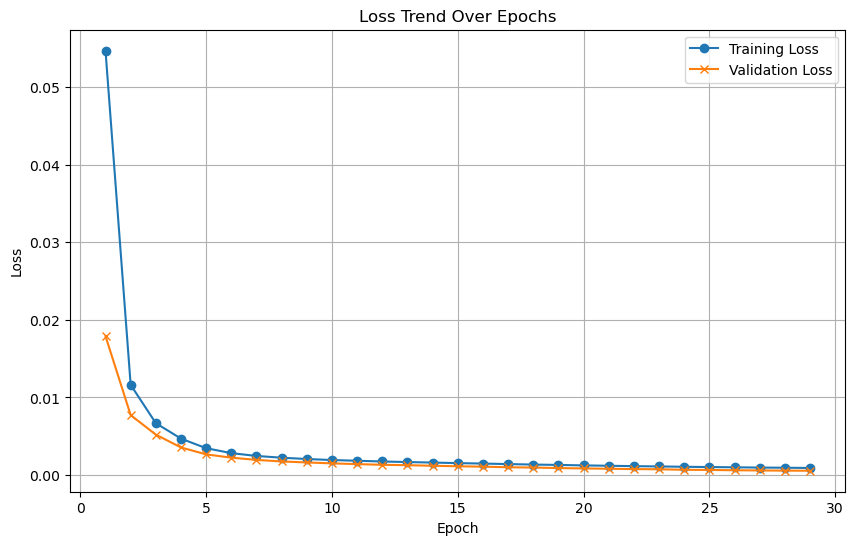

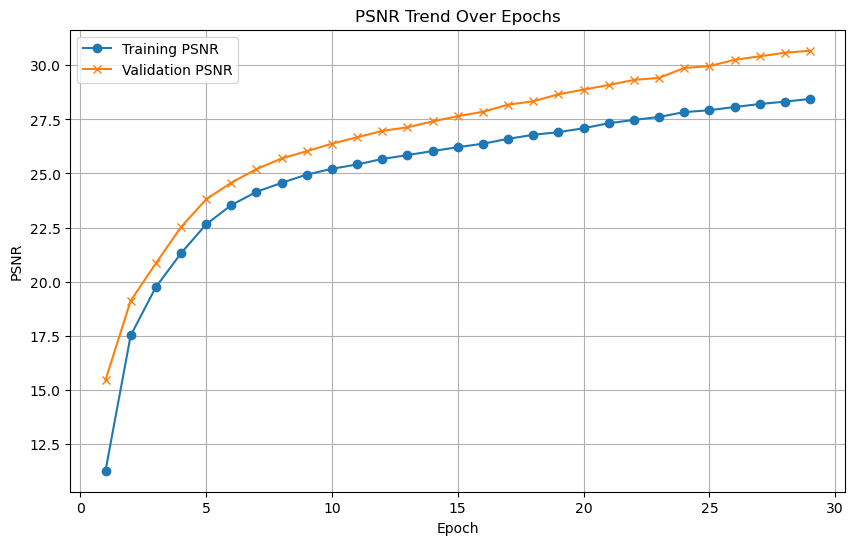

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2099
    Validation Batch [1/1], Loss: 2.2064
Validation Loss: 2.2064, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2064. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1650
    Validation Batch [1/1], Loss: 2.2063
Validation Loss: 2.2063, Validation Accuracy: 11.11%
Validation loss improved from 2.2064 to 2.2063. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1042
    Validation Batch [1/1], Loss: 2.2062
Validation Loss: 2.2062, Validation Accuracy: 11.11%
Validation loss improved from 2.2063 to 2.2062. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0804
    Validation Batch [1/1], Loss: 2.2061
Validation Loss: 2.2061, Validation Accuracy: 11.11%
Validation loss improved from 2.2062 to 2.2061. Saving model...

LOG: Epoch [5/1000

Epoch [20/1000] completed, Average Training Loss: 1.7563
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss improved from 2.2013 to 2.2004. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.7537
    Validation Batch [1/1], Loss: 2.1992
Validation Loss: 2.1992, Validation Accuracy: 11.11%
Validation loss improved from 2.2004 to 2.1992. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.7194
    Validation Batch [1/1], Loss: 2.1975
Validation Loss: 2.1975, Validation Accuracy: 11.11%
Validation loss improved from 2.1992 to 2.1975. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.7397
    Validation Batch [1/1], Loss: 2.1955
Validation Loss: 2.1955, Validation Accuracy: 11.11%
Validation loss improved from 2.1975 to 2.1955. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [2

Epoch [51/1000] completed, Average Training Loss: 1.4610
    Validation Batch [1/1], Loss: 1.8076
Validation Loss: 1.8076, Validation Accuracy: 55.56%
Validation loss improved from 1.8230 to 1.8076. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.4413
    Validation Batch [1/1], Loss: 1.7929
Validation Loss: 1.7929, Validation Accuracy: 60.00%
Validation loss improved from 1.8076 to 1.7929. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.4318
    Validation Batch [1/1], Loss: 1.7777
Validation Loss: 1.7777, Validation Accuracy: 60.00%
Validation loss improved from 1.7929 to 1.7777. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.4381
    Validation Batch [1/1], Loss: 1.7623
Validation Loss: 1.7623, Validation Accuracy: 60.00%
Validation loss improved from 1.7777 to 1.7623. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

Epoch [83/1000] completed, Average Training Loss: 1.2142
    Validation Batch [1/1], Loss: 1.4995
Validation Loss: 1.4995, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.2235
    Validation Batch [1/1], Loss: 1.4997
Validation Loss: 1.4997, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.2197
    Validation Batch [1/1], Loss: 1.4908
Validation Loss: 1.4908, Validation Accuracy: 64.44%
Validation loss improved from 1.4995 to 1.4908. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.1892
    Validation Batch [1/1], Loss: 1.4793
Validation Loss: 1.4793, Validation Accuracy: 64.44%
Validation loss improved from 1.4908 to 1.4793. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 1.3315
Validation Loss: 1.3315, Validation Accuracy: 64.44%
Validation loss improved from 1.3398 to 1.3315. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.9343
    Validation Batch [1/1], Loss: 1.3222
Validation Loss: 1.3222, Validation Accuracy: 64.44%
Validation loss improved from 1.3315 to 1.3222. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.9480
    Validation Batch [1/1], Loss: 1.3191
Validation Loss: 1.3191, Validation Accuracy: 64.44%
Validation loss improved from 1.3222 to 1.3191. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.9667
    Validation Batch [1/1], Loss: 1.3226
Validation Loss: 1.3226, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.9082
    Validation 

    Validation Batch [1/1], Loss: 1.2190
Validation Loss: 1.2190, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.7278
    Validation Batch [1/1], Loss: 1.2322
Validation Loss: 1.2322, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.7355
    Validation Batch [1/1], Loss: 1.2280
Validation Loss: 1.2280, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.7281
    Validation Batch [1/1], Loss: 1.2191
Validation Loss: 1.2191, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.6560
    Validation Batch [1/1], Loss: 1.2219
Validation Loss: 1.

Epoch [177/1000] completed, Average Training Loss: 0.5327
    Validation Batch [1/1], Loss: 1.1360
Validation Loss: 1.1360, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.5139
    Validation Batch [1/1], Loss: 1.1287
Validation Loss: 1.1287, Validation Accuracy: 66.67%
Validation loss improved from 1.1343 to 1.1287. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.5290
    Validation Batch [1/1], Loss: 1.1557
Validation Loss: 1.1557, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.5407
    Validation Batch [1/1], Loss: 1.1429
Validation Loss: 1.1429, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.0763
Validation Loss: 1.0763, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.3711
    Validation Batch [1/1], Loss: 1.0669
Validation Loss: 1.0669, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.3864
    Validation Batch [1/1], Loss: 1.0782
Validation Loss: 1.0782, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.3988
    Validation Batch [1/1], Loss: 1.1054
Validation Loss: 1.1054, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.4091
    Validation Batch [1/1], Loss: 1.0761
Validation Loss: 1.

Epoch [238/1000] completed, Average Training Loss: 0.2567
    Validation Batch [1/1], Loss: 1.0497
Validation Loss: 1.0497, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.2785
    Validation Batch [1/1], Loss: 1.0336
Validation Loss: 1.0336, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.2792
    Validation Batch [1/1], Loss: 1.0417
Validation Loss: 1.0417, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.2627
    Validation Batch [1/1], Loss: 1.0503
Validation Loss: 1.0503, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.296

Epoch [270/1000] completed, Average Training Loss: 0.2241
    Validation Batch [1/1], Loss: 1.0284
Validation Loss: 1.0284, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.2032
    Validation Batch [1/1], Loss: 1.0364
Validation Loss: 1.0364, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.2040
    Validation Batch [1/1], Loss: 1.0279
Validation Loss: 1.0279, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.2070
    Validation Batch [1/1], Loss: 1.0082
Validation Loss: 1.0082, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.205

Epoch [301/1000] completed, Average Training Loss: 0.1578
    Validation Batch [1/1], Loss: 1.0043
Validation Loss: 1.0043, Validation Accuracy: 73.33%
Validation loss improved from 1.0072 to 1.0043. Saving model...

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1588
    Validation Batch [1/1], Loss: 1.0155
Validation Loss: 1.0155, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.1473
    Validation Batch [1/1], Loss: 1.0273
Validation Loss: 1.0273, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.1446
    Validation Batch [1/1], Loss: 1.0756
Validation Loss: 1.0756, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training 

Epoch [332/1000] completed, Average Training Loss: 0.1151
    Validation Batch [1/1], Loss: 1.0898
Validation Loss: 1.0898, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1185
    Validation Batch [1/1], Loss: 1.0990
Validation Loss: 1.0990, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 1.1066
Validation Loss: 1.1066, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.1241
    Validation Batch [1/1], Loss: 1.0962
Validation Loss: 1.0962, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.110

    Validation Batch [1/1], Loss: 1.0649
Validation Loss: 1.0649, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0897
    Validation Batch [1/1], Loss: 1.0931
Validation Loss: 1.0931, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0857
    Validation Batch [1/1], Loss: 1.0936
Validation Loss: 1.0936, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0900
    Validation Batch [1/1], Loss: 1.0450
Validation Loss: 1.0450, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0906
    Validation Batch [1/1], Loss: 1.0233
Validation Loss

Epoch [397/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 1.0016
Validation Loss: 1.0016, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 1.0249
Validation Loss: 1.0249, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0852
    Validation Batch [1/1], Loss: 1.0688
Validation Loss: 1.0688, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 1.0926
Validation Loss: 1.0926, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.066

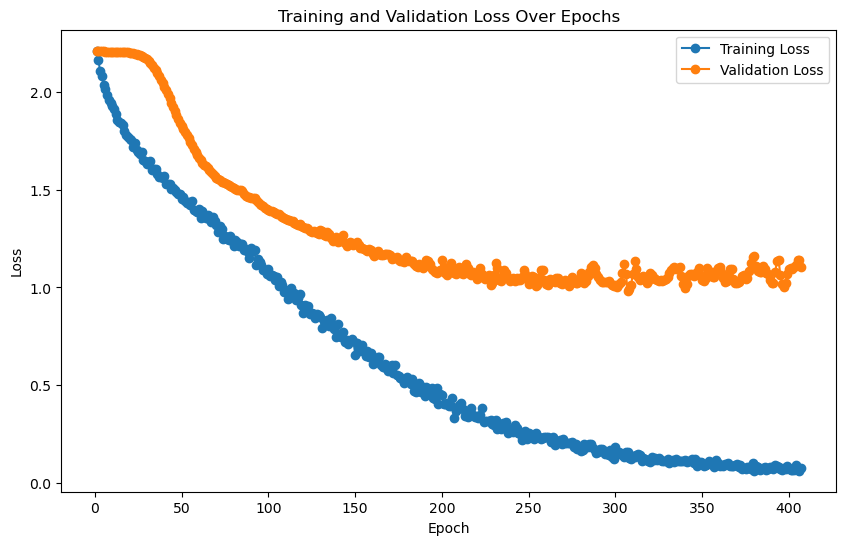

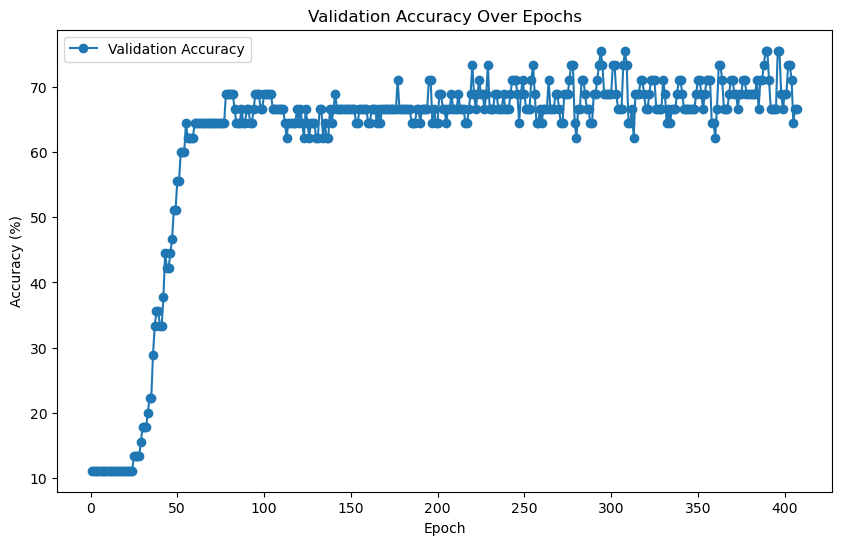


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.1854



Final Test Loss: 0.7726, Test Accuracy: 78.45%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42641, 64), Test labels shape: (42641,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.60      0.60      0.60         5
           2       0.60      0.60      0.60         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.75      0.60      0.67         5
           6       0.83      1.00      0.91         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42641, 64)
Test labels shape: (42641,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4230  |  Val Loss: 2.2361
Validation loss improved from inf to 2.2361.
[Epoch 2/1000] Train Loss: 2.1747  |  Val Loss: 2.0933
Validation loss improved from 2.2361 to 2.0933.
[Epoch 3/1000] Train Loss: 2.0450  |  Val Loss: 2.0013
Validation loss improved from 2.0933 to 2.0013.
[Epoch 4/1000] Train Loss: 1.9511  |  Val Loss: 1.9377
Validation loss improved from 2.0013 to 1.9377.
[Epoch 5/1000] Train Loss: 1.8847  |  Val Loss: 1.8798
Validation loss improved from 1.9377 to 1.8798.
[Epoch 6/1000] Train Loss: 1.8262  |  Val Loss: 1.8329
Validation loss improved from 1.8798 to 1.8329.
[Epoch 7/1000] Train Loss: 1.7783  |  Val Loss: 1.7925
Validation loss improved from 1.8329 to 1.7925.
[Epoch 8/1000] Train Loss: 1.7293  |  Val Loss: 1.7579
Validation loss improved from 1.7925 to 1.7579.
[Epoch 9/1000] Train Loss: 1.6815  |  Val Loss: 1.7264
Validation loss improved from 1.7579 to 1.7264.
[Epoch 10/1000] Train Loss: 1.6364  |  Val Loss: 1.6940
Validation loss impr

[Epoch 13/1000] Train Loss: 1.4887  |  Val Loss: 1.5798
Validation loss improved from 1.6181 to 1.5798.
[Epoch 14/1000] Train Loss: 1.4405  |  Val Loss: 1.5439
Validation loss improved from 1.5798 to 1.5439.
[Epoch 15/1000] Train Loss: 1.3891  |  Val Loss: 1.5074
Validation loss improved from 1.5439 to 1.5074.
[Epoch 16/1000] Train Loss: 1.3411  |  Val Loss: 1.4700
Validation loss improved from 1.5074 to 1.4700.
[Epoch 17/1000] Train Loss: 1.2913  |  Val Loss: 1.4307
Validation loss improved from 1.4700 to 1.4307.
[Epoch 18/1000] Train Loss: 1.2481  |  Val Loss: 1.3928
Validation loss improved from 1.4307 to 1.3928.
[Epoch 19/1000] Train Loss: 1.2024  |  Val Loss: 1.3596
Validation loss improved from 1.3928 to 1.3596.
[Epoch 20/1000] Train Loss: 1.1598  |  Val Loss: 1.3250
Validation loss improved from 1.3596 to 1.3250.
[Epoch 21/1000] Train Loss: 1.1152  |  Val Loss: 1.2911
Validation loss improved from 1.3250 to 1.2911.
[Epoch 22/1000] Train Loss: 1.0701  |  Val Loss: 1.2642
Validati

[Epoch 31/1000] Train Loss: 0.7536  |  Val Loss: 1.0721
Validation loss improved from 1.0945 to 1.0721.
[Epoch 32/1000] Train Loss: 0.7258  |  Val Loss: 1.0482
Validation loss improved from 1.0721 to 1.0482.
[Epoch 33/1000] Train Loss: 0.6989  |  Val Loss: 1.0346
Validation loss improved from 1.0482 to 1.0346.
[Epoch 34/1000] Train Loss: 0.6741  |  Val Loss: 1.0280
Validation loss improved from 1.0346 to 1.0280.
[Epoch 35/1000] Train Loss: 0.6482  |  Val Loss: 1.0244
Validation loss improved from 1.0280 to 1.0244.
[Epoch 36/1000] Train Loss: 0.6287  |  Val Loss: 1.0090
Validation loss improved from 1.0244 to 1.0090.
[Epoch 37/1000] Train Loss: 0.6030  |  Val Loss: 0.9841
Validation loss improved from 1.0090 to 0.9841.
[Epoch 38/1000] Train Loss: 0.5836  |  Val Loss: 0.9709
Validation loss improved from 0.9841 to 0.9709.
[Epoch 39/1000] Train Loss: 0.5732  |  Val Loss: 0.9646
Validation loss improved from 0.9709 to 0.9646.
[Epoch 40/1000] Train Loss: 0.5511  |  Val Loss: 0.9674
!! Valid

[Epoch 45/1000] Train Loss: 0.4843  |  Val Loss: 0.9316
Validation loss improved from 0.9539 to 0.9316.
[Epoch 46/1000] Train Loss: 0.4706  |  Val Loss: 0.9186
Validation loss improved from 0.9316 to 0.9186.
[Epoch 47/1000] Train Loss: 0.4573  |  Val Loss: 0.9353
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 0.4489  |  Val Loss: 0.9345
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/1000] Train Loss: 0.4333  |  Val Loss: 0.9316
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 50/1000] Train Loss: 0.4256  |  Val Loss: 0.9386
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 51/1000] Train Loss: 0.4216  |  Val Loss: 0.9330
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 52/1000] Train Loss: 0.4064  |  Val Loss: 0.9305
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 53/1000] Train Loss: 0.4052  |  Val Loss: 0.9331
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 54/1000] Train 

[Epoch 59/1000] Train Loss: 0.3586  |  Val Loss: 0.9742
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 60/1000] Train Loss: 0.3584  |  Val Loss: 0.9631
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 61/1000] Train Loss: 0.3463  |  Val Loss: 0.9616
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 62/1000] Train Loss: 0.3475  |  Val Loss: 0.9749
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 63/1000] Train Loss: 0.3409  |  Val Loss: 0.9974
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 64/1000] Train Loss: 0.3367  |  Val Loss: 0.9981
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 65/1000] Train Loss: 0.3249  |  Val Loss: 0.9911
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 66/1000] Train Loss: 0.3186  |  Val Loss: 1.0028
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 67/1000] Train Loss: 0.3174  |  Val Loss: 1.0135
!! Validation loss did NOT improve !! Patience: 21/100
[

[Epoch 75/1000] Train Loss: 0.2757  |  Val Loss: 1.0644
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 76/1000] Train Loss: 0.2720  |  Val Loss: 1.0738
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 77/1000] Train Loss: 0.2706  |  Val Loss: 1.0729
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 78/1000] Train Loss: 0.2627  |  Val Loss: 1.0794
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 79/1000] Train Loss: 0.2577  |  Val Loss: 1.0947
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 80/1000] Train Loss: 0.2530  |  Val Loss: 1.1131
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 81/1000] Train Loss: 0.2498  |  Val Loss: 1.1353
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 82/1000] Train Loss: 0.2541  |  Val Loss: 1.1399
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 83/1000] Train Loss: 0.2450  |  Val Loss: 1.1425
!! Validation loss did NOT improve !! Patience: 37/100
[

[Epoch 88/1000] Train Loss: 0.2440  |  Val Loss: 1.1930
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 89/1000] Train Loss: 0.2304  |  Val Loss: 1.2031
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 90/1000] Train Loss: 0.2390  |  Val Loss: 1.2466
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 91/1000] Train Loss: 0.2374  |  Val Loss: 1.2439
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 92/1000] Train Loss: 0.2207  |  Val Loss: 1.2497
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 93/1000] Train Loss: 0.2365  |  Val Loss: 1.2265
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 94/1000] Train Loss: 0.2200  |  Val Loss: 1.2264
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 95/1000] Train Loss: 0.2220  |  Val Loss: 1.2706
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 96/1000] Train Loss: 0.2283  |  Val Loss: 1.2798
!! Validation loss did NOT improve !! Patience: 50/100
[

[Epoch 100/1000] Train Loss: 0.2032  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 101/1000] Train Loss: 0.2375  |  Val Loss: 1.3074
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 102/1000] Train Loss: 0.2120  |  Val Loss: 1.3460
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 103/1000] Train Loss: 0.2061  |  Val Loss: 1.3788
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 104/1000] Train Loss: 0.2135  |  Val Loss: 1.3566
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 105/1000] Train Loss: 0.1862  |  Val Loss: 1.3551
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 106/1000] Train Loss: 0.1944  |  Val Loss: 1.3570
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 107/1000] Train Loss: 0.1948  |  Val Loss: 1.3455
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 108/1000] Train Loss: 0.1796  |  Val Loss: 1.3753
!! Validation loss did NOT improve !! Patience:

[Epoch 121/1000] Train Loss: 0.1636  |  Val Loss: 1.4831
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 122/1000] Train Loss: 0.1460  |  Val Loss: 1.5021
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 123/1000] Train Loss: 0.1564  |  Val Loss: 1.5338
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 124/1000] Train Loss: 0.1647  |  Val Loss: 1.5213
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 125/1000] Train Loss: 0.1527  |  Val Loss: 1.5349
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 126/1000] Train Loss: 0.1535  |  Val Loss: 1.5453
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 127/1000] Train Loss: 0.1502  |  Val Loss: 1.5512
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 128/1000] Train Loss: 0.1439  |  Val Loss: 1.5713
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 129/1000] Train Loss: 0.1460  |  Val Loss: 1.5826
!! Validation loss did NOT improve !! Patience:

[Epoch 137/1000] Train Loss: 0.1277  |  Val Loss: 1.6752
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 138/1000] Train Loss: 0.1223  |  Val Loss: 1.6901
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 139/1000] Train Loss: 0.1249  |  Val Loss: 1.6824
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 140/1000] Train Loss: 0.1219  |  Val Loss: 1.6849
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 141/1000] Train Loss: 0.1229  |  Val Loss: 1.7140
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 142/1000] Train Loss: 0.1219  |  Val Loss: 1.7436
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 143/1000] Train Loss: 0.1201  |  Val Loss: 1.7605
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 144/1000] Train Loss: 0.1190  |  Val Loss: 1.7411
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 145/1000] Train Loss: 0.1216  |  Val Loss: 1.7232
!! Validation loss did NOT improve !! Patience:

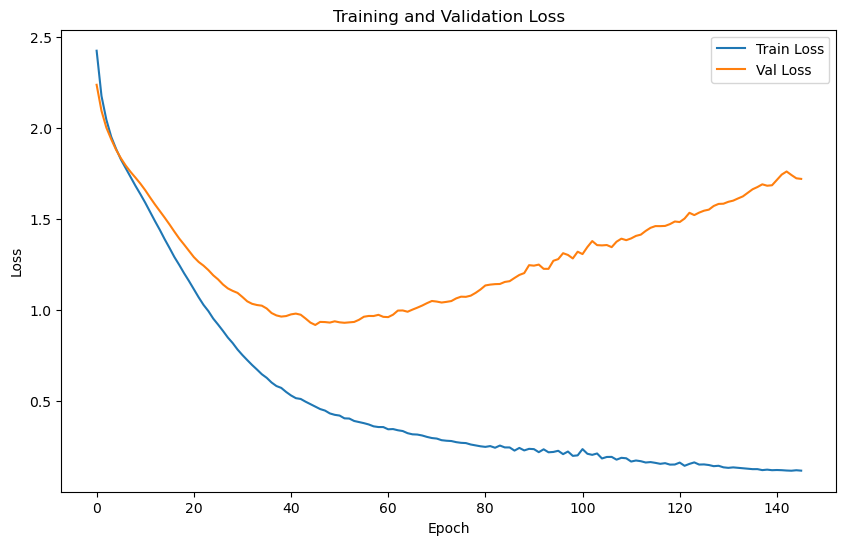

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.1334 | Test Accuracy: 69.62%


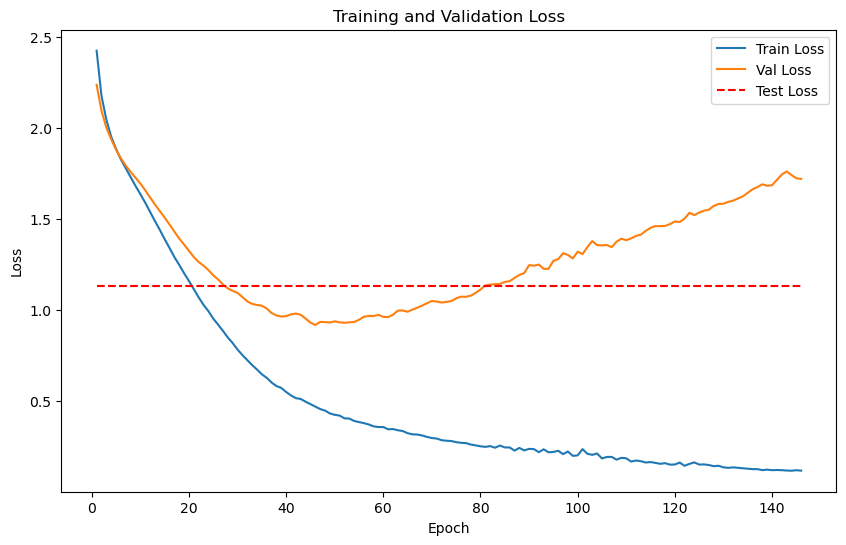

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.9577
Epoch [1/2000], Avg Train Loss: 8.9577
Epoch [1/2000], Avg Val Loss: 5.2448
Validation loss improved from inf to 5.2448. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.0971
Epoch [2/2000], Avg Train Loss: 9.0971
Epoch [2/2000], Avg Val Loss: 5.1836
Validation loss improved from 5.2448 to 5.1836. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.0170
Epoch [3/2000], Avg Train Loss: 9.0170
Epoch [3/2000], Avg Val Loss: 5.1243
Validation loss improved from 5.1836 to 5.1243. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.0010
Epoch [4/2000], Avg Train Loss: 9.0010
Epoch [4/2000], Avg Val Loss: 5.0664
Validation loss improved from 5.1243 to 5.0664. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7972
Epoch [5/2000], Avg Train Loss: 8.7972
Epoch [5/2000], Avg Val Loss: 5.0099
Validation loss improved from 5.0664 to 5.0099. Saving mode

    Batch [1/1], Train Loss: 8.6684
Epoch [10/2000], Avg Train Loss: 8.6684
Epoch [10/2000], Avg Val Loss: 4.7435
Validation loss improved from 4.7947 to 4.7435. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.5193
Epoch [11/2000], Avg Train Loss: 8.5193
Epoch [11/2000], Avg Val Loss: 4.6930
Validation loss improved from 4.7435 to 4.6930. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.4721
Epoch [12/2000], Avg Train Loss: 8.4721
Epoch [12/2000], Avg Val Loss: 4.6439
Validation loss improved from 4.6930 to 4.6439. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.2553
Epoch [13/2000], Avg Train Loss: 8.2553
Epoch [13/2000], Avg Val Loss: 4.5960
Validation loss improved from 4.6439 to 4.5960. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.3089
Epoch [14/2000], Avg Train Loss: 8.3089
Epoch [14/2000], Avg Val Loss: 4.5491
Validation loss improved from 4.5960 to 4.

    Batch [1/1], Train Loss: 7.6362
Epoch [20/2000], Avg Train Loss: 7.6362
Epoch [20/2000], Avg Val Loss: 4.2873
Validation loss improved from 4.3284 to 4.2873. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.6641
Epoch [21/2000], Avg Train Loss: 7.6641
Epoch [21/2000], Avg Val Loss: 4.2470
Validation loss improved from 4.2873 to 4.2470. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.6879
Epoch [22/2000], Avg Train Loss: 7.6879
Epoch [22/2000], Avg Val Loss: 4.2078
Validation loss improved from 4.2470 to 4.2078. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.7963
Epoch [23/2000], Avg Train Loss: 7.7963
Epoch [23/2000], Avg Val Loss: 4.1696
Validation loss improved from 4.2078 to 4.1696. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.4916
Epoch [24/2000], Avg Train Loss: 7.4916
Epoch [24/2000], Avg Val Loss: 4.1323
Validation loss improved from 4.1696 to 4.

Epoch [28/2000], Avg Val Loss: 3.9917
Validation loss improved from 4.0256 to 3.9917. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.0900
Epoch [29/2000], Avg Train Loss: 7.0900
Epoch [29/2000], Avg Val Loss: 3.9587
Validation loss improved from 3.9917 to 3.9587. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 7.0867
Epoch [30/2000], Avg Train Loss: 7.0867
Epoch [30/2000], Avg Val Loss: 3.9266
Validation loss improved from 3.9587 to 3.9266. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.9578
Epoch [31/2000], Avg Train Loss: 6.9578
Epoch [31/2000], Avg Val Loss: 3.8955
Validation loss improved from 3.9266 to 3.8955. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.9105
Epoch [32/2000], Avg Train Loss: 6.9105
Epoch [32/2000], Avg Val Loss: 3.8653
Validation loss improved from 3.8955 to 3.8653. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.3128
Epoch [47/2000], Avg Train Loss: 6.3128
Epoch [47/2000], Avg Val Loss: 3.5088
Validation loss improved from 3.5279 to 3.5088. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.1331
Epoch [48/2000], Avg Train Loss: 6.1331
Epoch [48/2000], Avg Val Loss: 3.4902
Validation loss improved from 3.5088 to 3.4902. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.1659
Epoch [49/2000], Avg Train Loss: 6.1659
Epoch [49/2000], Avg Val Loss: 3.4721
Validation loss improved from 3.4902 to 3.4721. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2496
Epoch [50/2000], Avg Train Loss: 6.2496
Epoch [50/2000], Avg Val Loss: 3.4547
Validation loss improved from 3.4721 to 3.4547. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.8745
Epoch [51/2000], Avg Train Loss: 5.8745
Epoch [51/2000], Avg Val Loss: 3.4379
Validation loss improved from 3.4547 to 3.

    Batch [1/1], Train Loss: 5.6948
Epoch [60/2000], Avg Train Loss: 5.6948
Epoch [60/2000], Avg Val Loss: 3.3094
Validation loss improved from 3.3219 to 3.3094. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5874
Epoch [61/2000], Avg Train Loss: 5.5874
Epoch [61/2000], Avg Val Loss: 3.2973
Validation loss improved from 3.3094 to 3.2973. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6363
Epoch [62/2000], Avg Train Loss: 5.6363
Epoch [62/2000], Avg Val Loss: 3.2856
Validation loss improved from 3.2973 to 3.2856. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.4444
Epoch [63/2000], Avg Train Loss: 5.4444
Epoch [63/2000], Avg Val Loss: 3.2743
Validation loss improved from 3.2856 to 3.2743. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.6165
Epoch [64/2000], Avg Train Loss: 5.6165
Epoch [64/2000], Avg Val Loss: 3.2634
Validation loss improved from 3.2743 to 3.

    Batch [1/1], Train Loss: 5.1415
Epoch [71/2000], Avg Train Loss: 5.1415
Epoch [71/2000], Avg Val Loss: 3.1964
Validation loss improved from 3.2051 to 3.1964. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.4836
Epoch [72/2000], Avg Train Loss: 5.4836
Epoch [72/2000], Avg Val Loss: 3.1879
Validation loss improved from 3.1964 to 3.1879. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2750
Epoch [73/2000], Avg Train Loss: 5.2750
Epoch [73/2000], Avg Val Loss: 3.1797
Validation loss improved from 3.1879 to 3.1797. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.3470
Epoch [74/2000], Avg Train Loss: 5.3470
Epoch [74/2000], Avg Val Loss: 3.1718
Validation loss improved from 3.1797 to 3.1718. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.0809
Epoch [75/2000], Avg Train Loss: 5.0809
Epoch [75/2000], Avg Val Loss: 3.1641
Validation loss improved from 3.1718 to 3.

    Batch [1/1], Train Loss: 5.1969
Epoch [77/2000], Avg Train Loss: 5.1969
Epoch [77/2000], Avg Val Loss: 3.1495
Validation loss improved from 3.1567 to 3.1495. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.0038
Epoch [78/2000], Avg Train Loss: 5.0038
Epoch [78/2000], Avg Val Loss: 3.1426
Validation loss improved from 3.1495 to 3.1426. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.1329
Epoch [79/2000], Avg Train Loss: 5.1329
Epoch [79/2000], Avg Val Loss: 3.1360
Validation loss improved from 3.1426 to 3.1360. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.0290
Epoch [80/2000], Avg Train Loss: 5.0290
Epoch [80/2000], Avg Val Loss: 3.1295
Validation loss improved from 3.1360 to 3.1295. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.8292
Epoch [81/2000], Avg Train Loss: 4.8292
Epoch [81/2000], Avg Val Loss: 3.1233
Validation loss improved from 3.1295 to 3.

    Batch [1/1], Train Loss: 4.7247
Epoch [93/2000], Avg Train Loss: 4.7247
Epoch [93/2000], Avg Val Loss: 3.0626
Validation loss improved from 3.0669 to 3.0626. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6279
Epoch [94/2000], Avg Train Loss: 4.6279
Epoch [94/2000], Avg Val Loss: 3.0585
Validation loss improved from 3.0626 to 3.0585. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.8109
Epoch [95/2000], Avg Train Loss: 4.8109
Epoch [95/2000], Avg Val Loss: 3.0546
Validation loss improved from 3.0585 to 3.0546. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.6334
Epoch [96/2000], Avg Train Loss: 4.6334
Epoch [96/2000], Avg Val Loss: 3.0508
Validation loss improved from 3.0546 to 3.0508. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.7124
Epoch [97/2000], Avg Train Loss: 4.7124
Epoch [97/2000], Avg Val Loss: 3.0471
Validation loss improved from 3.0508 to 3.

    Batch [1/1], Train Loss: 4.5818
Epoch [107/2000], Avg Train Loss: 4.5818
Epoch [107/2000], Avg Val Loss: 3.0145
Validation loss improved from 3.0175 to 3.0145. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.4620
Epoch [108/2000], Avg Train Loss: 4.4620
Epoch [108/2000], Avg Val Loss: 3.0116
Validation loss improved from 3.0145 to 3.0116. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.5015
Epoch [109/2000], Avg Train Loss: 4.5015
Epoch [109/2000], Avg Val Loss: 3.0087
Validation loss improved from 3.0116 to 3.0087. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.4547
Epoch [110/2000], Avg Train Loss: 4.4547
Epoch [110/2000], Avg Val Loss: 3.0060
Validation loss improved from 3.0087 to 3.0060. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.4705
Epoch [111/2000], Avg Train Loss: 4.4705
Epoch [111/2000], Avg Val Loss: 3.0034
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4701
Epoch [122/2000], Avg Train Loss: 4.4701
Epoch [122/2000], Avg Val Loss: 2.9778
Validation loss improved from 2.9800 to 2.9778. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.2829
Epoch [123/2000], Avg Train Loss: 4.2829
Epoch [123/2000], Avg Val Loss: 2.9758
Validation loss improved from 2.9778 to 2.9758. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.4599
Epoch [124/2000], Avg Train Loss: 4.4599
Epoch [124/2000], Avg Val Loss: 2.9737
Validation loss improved from 2.9758 to 2.9737. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.4161
Epoch [125/2000], Avg Train Loss: 4.4161
Epoch [125/2000], Avg Val Loss: 2.9717
Validation loss improved from 2.9737 to 2.9717. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.3829
Epoch [126/2000], Avg Train Loss: 4.3829
Epoch [126/2000], Avg Val Loss: 2.9697
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3610
Epoch [135/2000], Avg Train Loss: 4.3610
Epoch [135/2000], Avg Val Loss: 2.9526
Validation loss improved from 2.9544 to 2.9526. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.3492
Epoch [136/2000], Avg Train Loss: 4.3492
Epoch [136/2000], Avg Val Loss: 2.9507
Validation loss improved from 2.9526 to 2.9507. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.2672
Epoch [137/2000], Avg Train Loss: 4.2672
Epoch [137/2000], Avg Val Loss: 2.9489
Validation loss improved from 2.9507 to 2.9489. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 4.3064
Epoch [138/2000], Avg Train Loss: 4.3064
Epoch [138/2000], Avg Val Loss: 2.9471
Validation loss improved from 2.9489 to 2.9471. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.2487
Epoch [139/2000], Avg Train Loss: 4.2487
Epoch [139/2000], Avg Val Loss: 2.9454
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1258
Epoch [154/2000], Avg Train Loss: 4.1258
Epoch [154/2000], Avg Val Loss: 2.9210
Validation loss improved from 2.9225 to 2.9210. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.1554
Epoch [155/2000], Avg Train Loss: 4.1554
Epoch [155/2000], Avg Val Loss: 2.9195
Validation loss improved from 2.9210 to 2.9195. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.1994
Epoch [156/2000], Avg Train Loss: 4.1994
Epoch [156/2000], Avg Val Loss: 2.9181
Validation loss improved from 2.9195 to 2.9181. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.1891
Epoch [157/2000], Avg Train Loss: 4.1891
Epoch [157/2000], Avg Val Loss: 2.9166
Validation loss improved from 2.9181 to 2.9166. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.1594
Epoch [158/2000], Avg Train Loss: 4.1594
Epoch [158/2000], Avg Val Loss: 2.9152
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0881
Epoch [168/2000], Avg Train Loss: 4.0881
Epoch [168/2000], Avg Val Loss: 2.9009
Validation loss improved from 2.9023 to 2.9009. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.1284
Epoch [169/2000], Avg Train Loss: 4.1284
Epoch [169/2000], Avg Val Loss: 2.8995
Validation loss improved from 2.9009 to 2.8995. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.0636
Epoch [170/2000], Avg Train Loss: 4.0636
Epoch [170/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.8995 to 2.8981. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.1740
Epoch [171/2000], Avg Train Loss: 4.1740
Epoch [171/2000], Avg Val Loss: 2.8968
Validation loss improved from 2.8981 to 2.8968. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.0325
Epoch [172/2000], Avg Train Loss: 4.0325
Epoch [172/2000], Avg Val Loss: 2.8954
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0021
Epoch [184/2000], Avg Train Loss: 4.0021
Epoch [184/2000], Avg Val Loss: 2.8800
Validation loss improved from 2.8812 to 2.8800. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.0418
Epoch [185/2000], Avg Train Loss: 4.0418
Epoch [185/2000], Avg Val Loss: 2.8788
Validation loss improved from 2.8800 to 2.8788. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 3.9953
Epoch [186/2000], Avg Train Loss: 3.9953
Epoch [186/2000], Avg Val Loss: 2.8776
Validation loss improved from 2.8788 to 2.8776. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.9790
Epoch [187/2000], Avg Train Loss: 3.9790
Epoch [187/2000], Avg Val Loss: 2.8764
Validation loss improved from 2.8776 to 2.8764. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.9374
Epoch [188/2000], Avg Train Loss: 3.9374
Epoch [188/2000], Avg Val Loss: 2.8752
Validation loss improved fro

Epoch [200/2000], Avg Val Loss: 2.8610
Validation loss improved from 2.8622 to 2.8610. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 3.9909
Epoch [201/2000], Avg Train Loss: 3.9909
Epoch [201/2000], Avg Val Loss: 2.8598
Validation loss improved from 2.8610 to 2.8598. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.0046
Epoch [202/2000], Avg Train Loss: 4.0046
Epoch [202/2000], Avg Val Loss: 2.8587
Validation loss improved from 2.8598 to 2.8587. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.9580
Epoch [203/2000], Avg Train Loss: 3.9580
Epoch [203/2000], Avg Val Loss: 2.8575
Validation loss improved from 2.8587 to 2.8575. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.9849
Epoch [204/2000], Avg Train Loss: 3.9849
Epoch [204/2000], Avg Val Loss: 2.8563
Validation loss improved from 2.8575 to 2.8563. Saving model...

LOG: Epoch [205/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0039
Epoch [211/2000], Avg Train Loss: 4.0039
Epoch [211/2000], Avg Val Loss: 2.8480
Validation loss improved from 2.8492 to 2.8480. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 3.9879
Epoch [212/2000], Avg Train Loss: 3.9879
Epoch [212/2000], Avg Val Loss: 2.8469
Validation loss improved from 2.8480 to 2.8469. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 3.9388
Epoch [213/2000], Avg Train Loss: 3.9388
Epoch [213/2000], Avg Val Loss: 2.8458
Validation loss improved from 2.8469 to 2.8458. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.8599
Epoch [214/2000], Avg Train Loss: 3.8599
Epoch [214/2000], Avg Val Loss: 2.8446
Validation loss improved from 2.8458 to 2.8446. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.8822
Epoch [215/2000], Avg Train Loss: 3.8822
Epoch [215/2000], Avg Val Loss: 2.8435
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8534
Epoch [231/2000], Avg Train Loss: 3.8534
Epoch [231/2000], Avg Val Loss: 2.8258
Validation loss improved from 2.8269 to 2.8258. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.7935
Epoch [232/2000], Avg Train Loss: 3.7935
Epoch [232/2000], Avg Val Loss: 2.8248
Validation loss improved from 2.8258 to 2.8248. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.8707
Epoch [233/2000], Avg Train Loss: 3.8707
Epoch [233/2000], Avg Val Loss: 2.8237
Validation loss improved from 2.8248 to 2.8237. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.8830
Epoch [234/2000], Avg Train Loss: 3.8830
Epoch [234/2000], Avg Val Loss: 2.8226
Validation loss improved from 2.8237 to 2.8226. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.8224
Epoch [235/2000], Avg Train Loss: 3.8224
Epoch [235/2000], Avg Val Loss: 2.8216
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8370
Epoch [244/2000], Avg Train Loss: 3.8370
Epoch [244/2000], Avg Val Loss: 2.8122
Validation loss improved from 2.8132 to 2.8122. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 3.7076
Epoch [245/2000], Avg Train Loss: 3.7076
Epoch [245/2000], Avg Val Loss: 2.8111
Validation loss improved from 2.8122 to 2.8111. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.8255
Epoch [246/2000], Avg Train Loss: 3.8255
Epoch [246/2000], Avg Val Loss: 2.8102
Validation loss improved from 2.8111 to 2.8102. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.7987
Epoch [247/2000], Avg Train Loss: 3.7987
Epoch [247/2000], Avg Val Loss: 2.8092
Validation loss improved from 2.8102 to 2.8092. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.7989
Epoch [248/2000], Avg Train Loss: 3.7989
Epoch [248/2000], Avg Val Loss: 2.8082
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7565
Epoch [255/2000], Avg Train Loss: 3.7565
Epoch [255/2000], Avg Val Loss: 2.8012
Validation loss improved from 2.8022 to 2.8012. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.7738
Epoch [256/2000], Avg Train Loss: 3.7738
Epoch [256/2000], Avg Val Loss: 2.8002
Validation loss improved from 2.8012 to 2.8002. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.7610
Epoch [257/2000], Avg Train Loss: 3.7610
Epoch [257/2000], Avg Val Loss: 2.7992
Validation loss improved from 2.8002 to 2.7992. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.7602
Epoch [258/2000], Avg Train Loss: 3.7602
Epoch [258/2000], Avg Val Loss: 2.7983
Validation loss improved from 2.7992 to 2.7983. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.8187
Epoch [259/2000], Avg Train Loss: 3.8187
Epoch [259/2000], Avg Val Loss: 2.7973
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7453
Epoch [279/2000], Avg Train Loss: 3.7453
Epoch [279/2000], Avg Val Loss: 2.7782
Validation loss improved from 2.7792 to 2.7782. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.7295
Epoch [280/2000], Avg Train Loss: 3.7295
Epoch [280/2000], Avg Val Loss: 2.7773
Validation loss improved from 2.7782 to 2.7773. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.7052
Epoch [281/2000], Avg Train Loss: 3.7052
Epoch [281/2000], Avg Val Loss: 2.7763
Validation loss improved from 2.7773 to 2.7763. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.6856
Epoch [282/2000], Avg Train Loss: 3.6856
Epoch [282/2000], Avg Val Loss: 2.7754
Validation loss improved from 2.7763 to 2.7754. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.7087
Epoch [283/2000], Avg Train Loss: 3.7087
Epoch [283/2000], Avg Val Loss: 2.7745
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6344
Epoch [293/2000], Avg Train Loss: 3.6344
Epoch [293/2000], Avg Val Loss: 2.7648
Validation loss improved from 2.7657 to 2.7648. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 3.6881
Epoch [294/2000], Avg Train Loss: 3.6881
Epoch [294/2000], Avg Val Loss: 2.7638
Validation loss improved from 2.7648 to 2.7638. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 3.6418
Epoch [295/2000], Avg Train Loss: 3.6418
Epoch [295/2000], Avg Val Loss: 2.7628
Validation loss improved from 2.7638 to 2.7628. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 3.7466
Epoch [296/2000], Avg Train Loss: 3.7466
Epoch [296/2000], Avg Val Loss: 2.7619
Validation loss improved from 2.7628 to 2.7619. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.6294
Epoch [297/2000], Avg Train Loss: 3.6294
Epoch [297/2000], Avg Val Loss: 2.7609
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6974
Epoch [303/2000], Avg Train Loss: 3.6974
Epoch [303/2000], Avg Val Loss: 2.7556
Validation loss improved from 2.7565 to 2.7556. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.7230
Epoch [304/2000], Avg Train Loss: 3.7230
Epoch [304/2000], Avg Val Loss: 2.7548
Validation loss improved from 2.7556 to 2.7548. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.7061
Epoch [305/2000], Avg Train Loss: 3.7061
Epoch [305/2000], Avg Val Loss: 2.7540
Validation loss improved from 2.7548 to 2.7540. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.6385
Epoch [306/2000], Avg Train Loss: 3.6385
Epoch [306/2000], Avg Val Loss: 2.7532
Validation loss improved from 2.7540 to 2.7532. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.7224
Epoch [307/2000], Avg Train Loss: 3.7224
Epoch [307/2000], Avg Val Loss: 2.7525
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6085
Epoch [326/2000], Avg Train Loss: 3.6085
Epoch [326/2000], Avg Val Loss: 2.7381
Validation loss improved from 2.7388 to 2.7381. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.6114
Epoch [327/2000], Avg Train Loss: 3.6114
Epoch [327/2000], Avg Val Loss: 2.7374
Validation loss improved from 2.7381 to 2.7374. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.6283
Epoch [328/2000], Avg Train Loss: 3.6283
Epoch [328/2000], Avg Val Loss: 2.7366
Validation loss improved from 2.7374 to 2.7366. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.6475
Epoch [329/2000], Avg Train Loss: 3.6475
Epoch [329/2000], Avg Val Loss: 2.7360
Validation loss improved from 2.7366 to 2.7360. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.6019
Epoch [330/2000], Avg Train Loss: 3.6019
Epoch [330/2000], Avg Val Loss: 2.7353
Validation loss improved fro

Epoch [338/2000], Avg Val Loss: 2.7298
Validation loss improved from 2.7304 to 2.7298. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.5858
Epoch [339/2000], Avg Train Loss: 3.5858
Epoch [339/2000], Avg Val Loss: 2.7291
Validation loss improved from 2.7298 to 2.7291. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 3.5914
Epoch [340/2000], Avg Train Loss: 3.5914
Epoch [340/2000], Avg Val Loss: 2.7284
Validation loss improved from 2.7291 to 2.7284. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 3.5973
Epoch [341/2000], Avg Train Loss: 3.5973
Epoch [341/2000], Avg Val Loss: 2.7277
Validation loss improved from 2.7284 to 2.7277. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 3.5663
Epoch [342/2000], Avg Train Loss: 3.5663
Epoch [342/2000], Avg Val Loss: 2.7270
Validation loss improved from 2.7277 to 2.7270. Saving model...

LOG: Epoch [343/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5426
Epoch [345/2000], Avg Train Loss: 3.5426
Epoch [345/2000], Avg Val Loss: 2.7248
Validation loss improved from 2.7255 to 2.7248. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.6358
Epoch [346/2000], Avg Train Loss: 3.6358
Epoch [346/2000], Avg Val Loss: 2.7241
Validation loss improved from 2.7248 to 2.7241. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.6004
Epoch [347/2000], Avg Train Loss: 3.6004
Epoch [347/2000], Avg Val Loss: 2.7234
Validation loss improved from 2.7241 to 2.7234. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.5933
Epoch [348/2000], Avg Train Loss: 3.5933
Epoch [348/2000], Avg Val Loss: 2.7228
Validation loss improved from 2.7234 to 2.7228. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.5790
Epoch [349/2000], Avg Train Loss: 3.5790
Epoch [349/2000], Avg Val Loss: 2.7221
Validation loss improved fro

Epoch [369/2000], Avg Val Loss: 2.7106
Validation loss improved from 2.7112 to 2.7106. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.5629
Epoch [370/2000], Avg Train Loss: 3.5629
Epoch [370/2000], Avg Val Loss: 2.7100
Validation loss improved from 2.7106 to 2.7100. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.5851
Epoch [371/2000], Avg Train Loss: 3.5851
Epoch [371/2000], Avg Val Loss: 2.7094
Validation loss improved from 2.7100 to 2.7094. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.5471
Epoch [372/2000], Avg Train Loss: 3.5471
Epoch [372/2000], Avg Val Loss: 2.7088
Validation loss improved from 2.7094 to 2.7088. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.5674
Epoch [373/2000], Avg Train Loss: 3.5674
Epoch [373/2000], Avg Val Loss: 2.7082
Validation loss improved from 2.7088 to 2.7082. Saving model...

LOG: Epoch [374/2000] - Training
    Bat

Epoch [381/2000], Avg Val Loss: 2.7035
Validation loss improved from 2.7040 to 2.7035. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.5637
Epoch [382/2000], Avg Train Loss: 3.5637
Epoch [382/2000], Avg Val Loss: 2.7029
Validation loss improved from 2.7035 to 2.7029. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.6512
Epoch [383/2000], Avg Train Loss: 3.6512
Epoch [383/2000], Avg Val Loss: 2.7024
Validation loss improved from 2.7029 to 2.7024. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 3.5307
Epoch [384/2000], Avg Train Loss: 3.5307
Epoch [384/2000], Avg Val Loss: 2.7018
Validation loss improved from 2.7024 to 2.7018. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 3.5366
Epoch [385/2000], Avg Train Loss: 3.5366
Epoch [385/2000], Avg Val Loss: 2.7013
Validation loss improved from 2.7018 to 2.7013. Saving model...

LOG: Epoch [386/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5156
Epoch [415/2000], Avg Train Loss: 3.5156
Epoch [415/2000], Avg Val Loss: 2.6853
Validation loss improved from 2.6857 to 2.6853. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.4723
Epoch [416/2000], Avg Train Loss: 3.4723
Epoch [416/2000], Avg Val Loss: 2.6849
Validation loss improved from 2.6853 to 2.6849. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.4353
Epoch [417/2000], Avg Train Loss: 3.4353
Epoch [417/2000], Avg Val Loss: 2.6845
Validation loss improved from 2.6849 to 2.6845. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.4694
Epoch [418/2000], Avg Train Loss: 3.4694
Epoch [418/2000], Avg Val Loss: 2.6842
Validation loss improved from 2.6845 to 2.6842. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.4204
Epoch [419/2000], Avg Train Loss: 3.4204
Epoch [419/2000], Avg Val Loss: 2.6838
Validation loss improved fro

Epoch [429/2000], Avg Val Loss: 2.6798
Validation loss improved from 2.6801 to 2.6798. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.4288
Epoch [430/2000], Avg Train Loss: 3.4288
Epoch [430/2000], Avg Val Loss: 2.6794
Validation loss improved from 2.6798 to 2.6794. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 3.4105
Epoch [431/2000], Avg Train Loss: 3.4105
Epoch [431/2000], Avg Val Loss: 2.6790
Validation loss improved from 2.6794 to 2.6790. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 3.4486
Epoch [432/2000], Avg Train Loss: 3.4486
Epoch [432/2000], Avg Val Loss: 2.6786
Validation loss improved from 2.6790 to 2.6786. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.4731
Epoch [433/2000], Avg Train Loss: 3.4731
Epoch [433/2000], Avg Val Loss: 2.6782
Validation loss improved from 2.6786 to 2.6782. Saving model...

LOG: Epoch [434/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3928
Epoch [461/2000], Avg Train Loss: 3.3928
Epoch [461/2000], Avg Val Loss: 2.6689
Validation loss improved from 2.6693 to 2.6689. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.4240
Epoch [462/2000], Avg Train Loss: 3.4240
Epoch [462/2000], Avg Val Loss: 2.6686
Validation loss improved from 2.6689 to 2.6686. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.4890
Epoch [463/2000], Avg Train Loss: 3.4890
Epoch [463/2000], Avg Val Loss: 2.6682
Validation loss improved from 2.6686 to 2.6682. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.3843
Epoch [464/2000], Avg Train Loss: 3.3843
Epoch [464/2000], Avg Val Loss: 2.6678
Validation loss improved from 2.6682 to 2.6678. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.4153
Epoch [465/2000], Avg Train Loss: 3.4153
Epoch [465/2000], Avg Val Loss: 2.6674
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3458
Epoch [477/2000], Avg Train Loss: 3.3458
Epoch [477/2000], Avg Val Loss: 2.6628
Validation loss improved from 2.6631 to 2.6628. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 3.4406
Epoch [478/2000], Avg Train Loss: 3.4406
Epoch [478/2000], Avg Val Loss: 2.6625
Validation loss improved from 2.6628 to 2.6625. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 3.4252
Epoch [479/2000], Avg Train Loss: 3.4252
Epoch [479/2000], Avg Val Loss: 2.6622
Validation loss improved from 2.6625 to 2.6622. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.4375
Epoch [480/2000], Avg Train Loss: 3.4375
Epoch [480/2000], Avg Val Loss: 2.6619
Validation loss improved from 2.6622 to 2.6619. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.3966
Epoch [481/2000], Avg Train Loss: 3.3966
Epoch [481/2000], Avg Val Loss: 2.6616
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3194
Epoch [511/2000], Avg Train Loss: 3.3194
Epoch [511/2000], Avg Val Loss: 2.6535
Validation loss improved from 2.6538 to 2.6535. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 3.3864
Epoch [512/2000], Avg Train Loss: 3.3864
Epoch [512/2000], Avg Val Loss: 2.6532
Validation loss improved from 2.6535 to 2.6532. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.3379
Epoch [513/2000], Avg Train Loss: 3.3379
Epoch [513/2000], Avg Val Loss: 2.6528
Validation loss improved from 2.6532 to 2.6528. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 3.3657
Epoch [514/2000], Avg Train Loss: 3.3657
Epoch [514/2000], Avg Val Loss: 2.6525
Validation loss improved from 2.6528 to 2.6525. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 3.3506
Epoch [515/2000], Avg Train Loss: 3.3506
Epoch [515/2000], Avg Val Loss: 2.6522
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3201
Epoch [529/2000], Avg Train Loss: 3.3201
Epoch [529/2000], Avg Val Loss: 2.6486
Validation loss improved from 2.6488 to 2.6486. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.3278
Epoch [530/2000], Avg Train Loss: 3.3278
Epoch [530/2000], Avg Val Loss: 2.6484
Validation loss improved from 2.6486 to 2.6484. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.3688
Epoch [531/2000], Avg Train Loss: 3.3688
Epoch [531/2000], Avg Val Loss: 2.6482
Validation loss improved from 2.6484 to 2.6482. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 3.3230
Epoch [532/2000], Avg Train Loss: 3.3230
Epoch [532/2000], Avg Val Loss: 2.6481
Validation loss improved from 2.6482 to 2.6481. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 3.3546
Epoch [533/2000], Avg Train Loss: 3.3546
Epoch [533/2000], Avg Val Loss: 2.6479
Validation loss improved fro

Epoch [558/2000], Avg Val Loss: 2.6444
Validation loss improved from 2.6446 to 2.6444. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.3454
Epoch [559/2000], Avg Train Loss: 3.3454
Epoch [559/2000], Avg Val Loss: 2.6442
Validation loss improved from 2.6444 to 2.6442. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.2701
Epoch [560/2000], Avg Train Loss: 3.2701
Epoch [560/2000], Avg Val Loss: 2.6440
Validation loss improved from 2.6442 to 2.6440. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.3440
Epoch [561/2000], Avg Train Loss: 3.3440
Epoch [561/2000], Avg Val Loss: 2.6439
Validation loss improved from 2.6440 to 2.6439. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.2790
Epoch [562/2000], Avg Train Loss: 3.2790
Epoch [562/2000], Avg Val Loss: 2.6437
Validation loss improved from 2.6439 to 2.6437. Saving model...

LOG: Epoch [563/2000] - Training
    Bat

Epoch [579/2000], Avg Val Loss: 2.6409
Validation loss improved from 2.6410 to 2.6409. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.2976
Epoch [580/2000], Avg Train Loss: 3.2976
Epoch [580/2000], Avg Val Loss: 2.6407
Validation loss improved from 2.6409 to 2.6407. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.3110
Epoch [581/2000], Avg Train Loss: 3.3110
Epoch [581/2000], Avg Val Loss: 2.6406
Validation loss improved from 2.6407 to 2.6406. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 3.2878
Epoch [582/2000], Avg Train Loss: 3.2878
Epoch [582/2000], Avg Val Loss: 2.6405
Validation loss improved from 2.6406 to 2.6405. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.2662
Epoch [583/2000], Avg Train Loss: 3.2662
Epoch [583/2000], Avg Val Loss: 2.6403
Validation loss improved from 2.6405 to 2.6403. Saving model...

LOG: Epoch [584/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2939
Epoch [602/2000], Avg Train Loss: 3.2939
Epoch [602/2000], Avg Val Loss: 2.6377
Validation loss improved from 2.6379 to 2.6377. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.2968
Epoch [603/2000], Avg Train Loss: 3.2968
Epoch [603/2000], Avg Val Loss: 2.6376
Validation loss improved from 2.6377 to 2.6376. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 3.2293
Epoch [604/2000], Avg Train Loss: 3.2293
Epoch [604/2000], Avg Val Loss: 2.6375
Validation loss improved from 2.6376 to 2.6375. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.2859
Epoch [605/2000], Avg Train Loss: 3.2859
Epoch [605/2000], Avg Val Loss: 2.6373
Validation loss improved from 2.6375 to 2.6373. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.3388
Epoch [606/2000], Avg Train Loss: 3.3388
Epoch [606/2000], Avg Val Loss: 2.6371
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2494
Epoch [625/2000], Avg Train Loss: 3.2494
Epoch [625/2000], Avg Val Loss: 2.6356
Validation loss did not improve. Patience: 4/100

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.2524
Epoch [626/2000], Avg Train Loss: 3.2524
Epoch [626/2000], Avg Val Loss: 2.6356
Validation loss did not improve. Patience: 5/100

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 3.2601
Epoch [627/2000], Avg Train Loss: 3.2601
Epoch [627/2000], Avg Val Loss: 2.6356
Validation loss improved from 2.6356 to 2.6356. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.2417
Epoch [628/2000], Avg Train Loss: 3.2417
Epoch [628/2000], Avg Val Loss: 2.6356
Validation loss improved from 2.6356 to 2.6356. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.2318
Epoch [629/2000], Avg Train Loss: 3.2318
Epoch [629/2000], Avg Val Loss: 2.6354
Validation loss improved from 2.6356 to 2.6354. Saving mod

    Batch [1/1], Train Loss: 3.2243
Epoch [651/2000], Avg Train Loss: 3.2243
Epoch [651/2000], Avg Val Loss: 2.6349
Validation loss improved from 2.6350 to 2.6349. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.2012
Epoch [652/2000], Avg Train Loss: 3.2012
Epoch [652/2000], Avg Val Loss: 2.6349
Validation loss improved from 2.6349 to 2.6349. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.1683
Epoch [653/2000], Avg Train Loss: 3.1683
Epoch [653/2000], Avg Val Loss: 2.6348
Validation loss improved from 2.6349 to 2.6348. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.2883
Epoch [654/2000], Avg Train Loss: 3.2883
Epoch [654/2000], Avg Val Loss: 2.6347
Validation loss improved from 2.6348 to 2.6347. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.2823
Epoch [655/2000], Avg Train Loss: 3.2823
Epoch [655/2000], Avg Val Loss: 2.6345
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2206
Epoch [674/2000], Avg Train Loss: 3.2206
Epoch [674/2000], Avg Val Loss: 2.6352
Validation loss did not improve. Patience: 17/100

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.2282
Epoch [675/2000], Avg Train Loss: 3.2282
Epoch [675/2000], Avg Val Loss: 2.6352
Validation loss did not improve. Patience: 18/100

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.2391
Epoch [676/2000], Avg Train Loss: 3.2391
Epoch [676/2000], Avg Val Loss: 2.6353
Validation loss did not improve. Patience: 19/100

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.2147
Epoch [677/2000], Avg Train Loss: 3.2147
Epoch [677/2000], Avg Val Loss: 2.6354
Validation loss did not improve. Patience: 20/100

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.2275
Epoch [678/2000], Avg Train Loss: 3.2275
Epoch [678/2000], Avg Val Loss: 2.6354
Validation loss did not improve. Patience: 21/100

LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 3.1917
Epoch [696/2000], Avg Train Loss: 3.1917
Epoch [696/2000], Avg Val Loss: 2.6358
Validation loss did not improve. Patience: 39/100

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.1628
Epoch [697/2000], Avg Train Loss: 3.1628
Epoch [697/2000], Avg Val Loss: 2.6359
Validation loss did not improve. Patience: 40/100

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.1917
Epoch [698/2000], Avg Train Loss: 3.1917
Epoch [698/2000], Avg Val Loss: 2.6359
Validation loss did not improve. Patience: 41/100

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.2039
Epoch [699/2000], Avg Train Loss: 3.2039
Epoch [699/2000], Avg Val Loss: 2.6360
Validation loss did not improve. Patience: 42/100

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.1814
Epoch [700/2000], Avg Train Loss: 3.1814
Epoch [700/2000], Avg Val Loss: 2.6360
Validation loss did not improve. Patience: 43/100

LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 3.1474
Epoch [722/2000], Avg Train Loss: 3.1474
Epoch [722/2000], Avg Val Loss: 2.6366
Validation loss did not improve. Patience: 65/100

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.2164
Epoch [723/2000], Avg Train Loss: 3.2164
Epoch [723/2000], Avg Val Loss: 2.6367
Validation loss did not improve. Patience: 66/100

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.1510
Epoch [724/2000], Avg Train Loss: 3.1510
Epoch [724/2000], Avg Val Loss: 2.6367
Validation loss did not improve. Patience: 67/100

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.2111
Epoch [725/2000], Avg Train Loss: 3.2111
Epoch [725/2000], Avg Val Loss: 2.6367
Validation loss did not improve. Patience: 68/100

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.1879
Epoch [726/2000], Avg Train Loss: 3.1879
Epoch [726/2000], Avg Val Loss: 2.6368
Validation loss did not improve. Patience: 69/100

LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 3.1383
Epoch [742/2000], Avg Train Loss: 3.1383
Epoch [742/2000], Avg Val Loss: 2.6378
Validation loss did not improve. Patience: 85/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.1262
Epoch [743/2000], Avg Train Loss: 3.1262
Epoch [743/2000], Avg Val Loss: 2.6379
Validation loss did not improve. Patience: 86/100

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.1598
Epoch [744/2000], Avg Train Loss: 3.1598
Epoch [744/2000], Avg Val Loss: 2.6379
Validation loss did not improve. Patience: 87/100

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.1464
Epoch [745/2000], Avg Train Loss: 3.1464
Epoch [745/2000], Avg Val Loss: 2.6380
Validation loss did not improve. Patience: 88/100

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.1603
Epoch [746/2000], Avg Train Loss: 3.1603
Epoch [746/2000], Avg Val Loss: 2.6380
Validation loss did not improve. Patience: 89/100

LOG: Epoch [747/2000] - Training


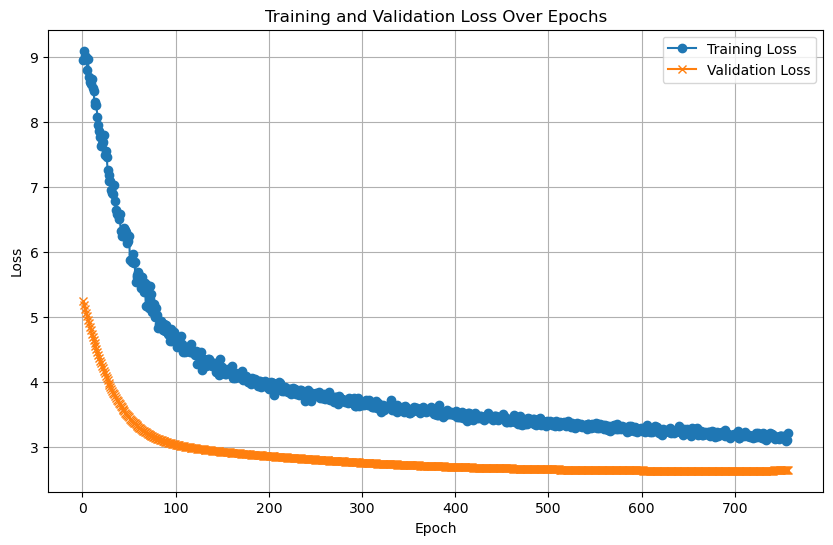

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.9952


Test Batch [20/167], Loss: 4.8275
Test Batch [30/167], Loss: 4.7644
Test Batch [40/167], Loss: 4.9700
Test Batch [50/167], Loss: 4.8144
Test Batch [60/167], Loss: 4.7943
Test Batch [70/167], Loss: 4.8057
Test Batch [80/167], Loss: 5.2603
Test Batch [90/167], Loss: 5.2789
Test Batch [100/167], Loss: 4.9515
Test Batch [110/167], Loss: 5.3581
Test Batch [120/167], Loss: 5.4245
Test Batch [130/167], Loss: 5.2681
Test Batch [140/167], Loss: 5.4345
Test Batch [150/167], Loss: 5.1810
Test Batch [160/167], Loss: 5.0076



Test Loss: 5.0306


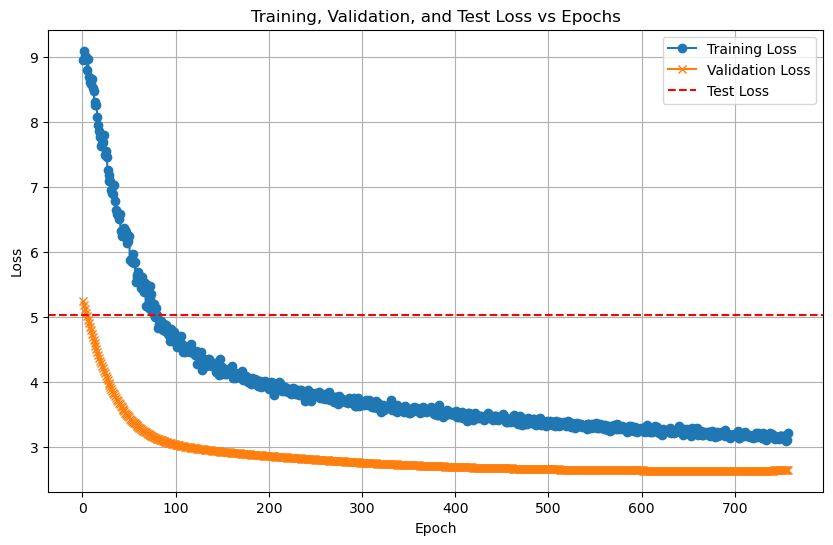

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.60      0.60      0.60         5
           2       0.33      0.40      0.36         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.75      0.60      0.67         5
           6       0.83      1.00      0.91         5
           7       0.50      0.40      0.44         5
           8       0.83      1.00      0.91         5

    accuracy                           0.73        45
   macro avg       0.74      0.73      0.73        45
weighted avg       0.74      0.73      0.73        45


LOG: Evaluating on the test set...
Test Accuracy: 72.11%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5884  |  Val Loss: 2.5954
Validation loss improved from inf to 2.5954.


[Epoch 2/1000] Train Loss: 2.5567  |  Val Loss: 2.5646
Validation loss improved from 2.5954 to 2.5646.
[Epoch 3/1000] Train Loss: 2.5243  |  Val Loss: 2.5350
Validation loss improved from 2.5646 to 2.5350.
[Epoch 4/1000] Train Loss: 2.4962  |  Val Loss: 2.5075
Validation loss improved from 2.5350 to 2.5075.
[Epoch 5/1000] Train Loss: 2.4672  |  Val Loss: 2.4817
Validation loss improved from 2.5075 to 2.4817.
[Epoch 6/1000] Train Loss: 2.4388  |  Val Loss: 2.4564
Validation loss improved from 2.4817 to 2.4564.
[Epoch 7/1000] Train Loss: 2.4120  |  Val Loss: 2.4318
Validation loss improved from 2.4564 to 2.4318.
[Epoch 8/1000] Train Loss: 2.3904  |  Val Loss: 2.4087
Validation loss improved from 2.4318 to 2.4087.
[Epoch 9/1000] Train Loss: 2.3665  |  Val Loss: 2.3866
Validation loss improved from 2.4087 to 2.3866.
[Epoch 10/1000] Train Loss: 2.3453  |  Val Loss: 2.3657
Validation loss improved from 2.3866 to 2.3657.


[Epoch 11/1000] Train Loss: 2.3223  |  Val Loss: 2.3455
Validation loss improved from 2.3657 to 2.3455.
[Epoch 12/1000] Train Loss: 2.3021  |  Val Loss: 2.3259
Validation loss improved from 2.3455 to 2.3259.
[Epoch 13/1000] Train Loss: 2.2837  |  Val Loss: 2.3079
Validation loss improved from 2.3259 to 2.3079.
[Epoch 14/1000] Train Loss: 2.2646  |  Val Loss: 2.2906
Validation loss improved from 2.3079 to 2.2906.
[Epoch 15/1000] Train Loss: 2.2478  |  Val Loss: 2.2738
Validation loss improved from 2.2906 to 2.2738.
[Epoch 16/1000] Train Loss: 2.2309  |  Val Loss: 2.2570
Validation loss improved from 2.2738 to 2.2570.
[Epoch 17/1000] Train Loss: 2.2146  |  Val Loss: 2.2408
Validation loss improved from 2.2570 to 2.2408.
[Epoch 18/1000] Train Loss: 2.1984  |  Val Loss: 2.2250
Validation loss improved from 2.2408 to 2.2250.
[Epoch 19/1000] Train Loss: 2.1828  |  Val Loss: 2.2098
Validation loss improved from 2.2250 to 2.2098.
[Epoch 20/1000] Train Loss: 2.1672  |  Val Loss: 2.1953
Validati

[Epoch 40/1000] Train Loss: 1.9221  |  Val Loss: 1.9589
Validation loss improved from 1.9691 to 1.9589.
[Epoch 41/1000] Train Loss: 1.9111  |  Val Loss: 1.9486
Validation loss improved from 1.9589 to 1.9486.
[Epoch 42/1000] Train Loss: 1.9004  |  Val Loss: 1.9381
Validation loss improved from 1.9486 to 1.9381.
[Epoch 43/1000] Train Loss: 1.8888  |  Val Loss: 1.9274
Validation loss improved from 1.9381 to 1.9274.
[Epoch 44/1000] Train Loss: 1.8783  |  Val Loss: 1.9166
Validation loss improved from 1.9274 to 1.9166.
[Epoch 45/1000] Train Loss: 1.8670  |  Val Loss: 1.9058
Validation loss improved from 1.9166 to 1.9058.
[Epoch 46/1000] Train Loss: 1.8557  |  Val Loss: 1.8953
Validation loss improved from 1.9058 to 1.8953.


[Epoch 47/1000] Train Loss: 1.8446  |  Val Loss: 1.8849
Validation loss improved from 1.8953 to 1.8849.
[Epoch 48/1000] Train Loss: 1.8339  |  Val Loss: 1.8745
Validation loss improved from 1.8849 to 1.8745.
[Epoch 49/1000] Train Loss: 1.8227  |  Val Loss: 1.8643
Validation loss improved from 1.8745 to 1.8643.
[Epoch 50/1000] Train Loss: 1.8121  |  Val Loss: 1.8540
Validation loss improved from 1.8643 to 1.8540.
[Epoch 51/1000] Train Loss: 1.8014  |  Val Loss: 1.8437
Validation loss improved from 1.8540 to 1.8437.
[Epoch 52/1000] Train Loss: 1.7907  |  Val Loss: 1.8334
Validation loss improved from 1.8437 to 1.8334.
[Epoch 53/1000] Train Loss: 1.7797  |  Val Loss: 1.8230
Validation loss improved from 1.8334 to 1.8230.
[Epoch 54/1000] Train Loss: 1.7694  |  Val Loss: 1.8127
Validation loss improved from 1.8230 to 1.8127.
[Epoch 55/1000] Train Loss: 1.7587  |  Val Loss: 1.8026
Validation loss improved from 1.8127 to 1.8026.
[Epoch 56/1000] Train Loss: 1.7476  |  Val Loss: 1.7927
Validati

[Epoch 60/1000] Train Loss: 1.7071  |  Val Loss: 1.7538
Validation loss improved from 1.7634 to 1.7538.
[Epoch 61/1000] Train Loss: 1.6968  |  Val Loss: 1.7445
Validation loss improved from 1.7538 to 1.7445.
[Epoch 62/1000] Train Loss: 1.6868  |  Val Loss: 1.7353
Validation loss improved from 1.7445 to 1.7353.
[Epoch 63/1000] Train Loss: 1.6777  |  Val Loss: 1.7263
Validation loss improved from 1.7353 to 1.7263.
[Epoch 64/1000] Train Loss: 1.6675  |  Val Loss: 1.7176
Validation loss improved from 1.7263 to 1.7176.
[Epoch 65/1000] Train Loss: 1.6581  |  Val Loss: 1.7089
Validation loss improved from 1.7176 to 1.7089.
[Epoch 66/1000] Train Loss: 1.6486  |  Val Loss: 1.7005
Validation loss improved from 1.7089 to 1.7005.
[Epoch 67/1000] Train Loss: 1.6390  |  Val Loss: 1.6923
Validation loss improved from 1.7005 to 1.6923.
[Epoch 68/1000] Train Loss: 1.6299  |  Val Loss: 1.6841
Validation loss improved from 1.6923 to 1.6841.
[Epoch 69/1000] Train Loss: 1.6211  |  Val Loss: 1.6759
Validati

[Epoch 83/1000] Train Loss: 1.4974  |  Val Loss: 1.5658
Validation loss improved from 1.5734 to 1.5658.
[Epoch 84/1000] Train Loss: 1.4890  |  Val Loss: 1.5584
Validation loss improved from 1.5658 to 1.5584.
[Epoch 85/1000] Train Loss: 1.4803  |  Val Loss: 1.5511
Validation loss improved from 1.5584 to 1.5511.
[Epoch 86/1000] Train Loss: 1.4718  |  Val Loss: 1.5439
Validation loss improved from 1.5511 to 1.5439.
[Epoch 87/1000] Train Loss: 1.4635  |  Val Loss: 1.5366
Validation loss improved from 1.5439 to 1.5366.
[Epoch 88/1000] Train Loss: 1.4553  |  Val Loss: 1.5293
Validation loss improved from 1.5366 to 1.5293.
[Epoch 89/1000] Train Loss: 1.4469  |  Val Loss: 1.5220
Validation loss improved from 1.5293 to 1.5220.
[Epoch 90/1000] Train Loss: 1.4387  |  Val Loss: 1.5148
Validation loss improved from 1.5220 to 1.5148.
[Epoch 91/1000] Train Loss: 1.4307  |  Val Loss: 1.5075
Validation loss improved from 1.5148 to 1.5075.
[Epoch 92/1000] Train Loss: 1.4224  |  Val Loss: 1.5004
Validati

[Epoch 104/1000] Train Loss: 1.3293  |  Val Loss: 1.4205
Validation loss improved from 1.4269 to 1.4205.
[Epoch 105/1000] Train Loss: 1.3220  |  Val Loss: 1.4142
Validation loss improved from 1.4205 to 1.4142.
[Epoch 106/1000] Train Loss: 1.3143  |  Val Loss: 1.4079
Validation loss improved from 1.4142 to 1.4079.
[Epoch 107/1000] Train Loss: 1.3067  |  Val Loss: 1.4017
Validation loss improved from 1.4079 to 1.4017.
[Epoch 108/1000] Train Loss: 1.2993  |  Val Loss: 1.3955
Validation loss improved from 1.4017 to 1.3955.
[Epoch 109/1000] Train Loss: 1.2917  |  Val Loss: 1.3893
Validation loss improved from 1.3955 to 1.3893.
[Epoch 110/1000] Train Loss: 1.2844  |  Val Loss: 1.3832
Validation loss improved from 1.3893 to 1.3832.
[Epoch 111/1000] Train Loss: 1.2767  |  Val Loss: 1.3772
Validation loss improved from 1.3832 to 1.3772.
[Epoch 112/1000] Train Loss: 1.2692  |  Val Loss: 1.3713
Validation loss improved from 1.3772 to 1.3713.
[Epoch 113/1000] Train Loss: 1.2617  |  Val Loss: 1.365

[Epoch 129/1000] Train Loss: 1.1493  |  Val Loss: 1.2737
Validation loss improved from 1.2791 to 1.2737.
[Epoch 130/1000] Train Loss: 1.1427  |  Val Loss: 1.2684
Validation loss improved from 1.2737 to 1.2684.
[Epoch 131/1000] Train Loss: 1.1362  |  Val Loss: 1.2632
Validation loss improved from 1.2684 to 1.2632.
[Epoch 132/1000] Train Loss: 1.1298  |  Val Loss: 1.2582
Validation loss improved from 1.2632 to 1.2582.
[Epoch 133/1000] Train Loss: 1.1236  |  Val Loss: 1.2533
Validation loss improved from 1.2582 to 1.2533.
[Epoch 134/1000] Train Loss: 1.1178  |  Val Loss: 1.2483
Validation loss improved from 1.2533 to 1.2483.
[Epoch 135/1000] Train Loss: 1.1114  |  Val Loss: 1.2433
Validation loss improved from 1.2483 to 1.2433.
[Epoch 136/1000] Train Loss: 1.1053  |  Val Loss: 1.2383
Validation loss improved from 1.2433 to 1.2383.
[Epoch 137/1000] Train Loss: 1.0994  |  Val Loss: 1.2334
Validation loss improved from 1.2383 to 1.2334.
[Epoch 138/1000] Train Loss: 1.0933  |  Val Loss: 1.228

[Epoch 147/1000] Train Loss: 1.0414  |  Val Loss: 1.1829
Validation loss improved from 1.1878 to 1.1829.
[Epoch 148/1000] Train Loss: 1.0356  |  Val Loss: 1.1782
Validation loss improved from 1.1829 to 1.1782.
[Epoch 149/1000] Train Loss: 1.0301  |  Val Loss: 1.1736
Validation loss improved from 1.1782 to 1.1736.
[Epoch 150/1000] Train Loss: 1.0246  |  Val Loss: 1.1691
Validation loss improved from 1.1736 to 1.1691.
[Epoch 151/1000] Train Loss: 1.0192  |  Val Loss: 1.1649
Validation loss improved from 1.1691 to 1.1649.
[Epoch 152/1000] Train Loss: 1.0136  |  Val Loss: 1.1608
Validation loss improved from 1.1649 to 1.1608.
[Epoch 153/1000] Train Loss: 1.0085  |  Val Loss: 1.1567
Validation loss improved from 1.1608 to 1.1567.
[Epoch 154/1000] Train Loss: 1.0030  |  Val Loss: 1.1526
Validation loss improved from 1.1567 to 1.1526.
[Epoch 155/1000] Train Loss: 0.9976  |  Val Loss: 1.1484
Validation loss improved from 1.1526 to 1.1484.
[Epoch 156/1000] Train Loss: 0.9922  |  Val Loss: 1.144

[Epoch 174/1000] Train Loss: 0.9029  |  Val Loss: 1.0715
Validation loss improved from 1.0757 to 1.0715.
[Epoch 175/1000] Train Loss: 0.8982  |  Val Loss: 1.0674
Validation loss improved from 1.0715 to 1.0674.
[Epoch 176/1000] Train Loss: 0.8936  |  Val Loss: 1.0636
Validation loss improved from 1.0674 to 1.0636.
[Epoch 177/1000] Train Loss: 0.8890  |  Val Loss: 1.0598
Validation loss improved from 1.0636 to 1.0598.
[Epoch 178/1000] Train Loss: 0.8844  |  Val Loss: 1.0562
Validation loss improved from 1.0598 to 1.0562.
[Epoch 179/1000] Train Loss: 0.8800  |  Val Loss: 1.0528
Validation loss improved from 1.0562 to 1.0528.
[Epoch 180/1000] Train Loss: 0.8755  |  Val Loss: 1.0495
Validation loss improved from 1.0528 to 1.0495.
[Epoch 181/1000] Train Loss: 0.8709  |  Val Loss: 1.0462
Validation loss improved from 1.0495 to 1.0462.
[Epoch 182/1000] Train Loss: 0.8663  |  Val Loss: 1.0428
Validation loss improved from 1.0462 to 1.0428.
[Epoch 183/1000] Train Loss: 0.8620  |  Val Loss: 1.039

[Epoch 197/1000] Train Loss: 0.8031  |  Val Loss: 0.9910
Validation loss improved from 0.9938 to 0.9910.
[Epoch 198/1000] Train Loss: 0.7989  |  Val Loss: 0.9881
Validation loss improved from 0.9910 to 0.9881.
[Epoch 199/1000] Train Loss: 0.7951  |  Val Loss: 0.9852
Validation loss improved from 0.9881 to 0.9852.
[Epoch 200/1000] Train Loss: 0.7911  |  Val Loss: 0.9821
Validation loss improved from 0.9852 to 0.9821.
[Epoch 201/1000] Train Loss: 0.7871  |  Val Loss: 0.9789
Validation loss improved from 0.9821 to 0.9789.
[Epoch 202/1000] Train Loss: 0.7833  |  Val Loss: 0.9757
Validation loss improved from 0.9789 to 0.9757.
[Epoch 203/1000] Train Loss: 0.7794  |  Val Loss: 0.9726
Validation loss improved from 0.9757 to 0.9726.
[Epoch 204/1000] Train Loss: 0.7756  |  Val Loss: 0.9695
Validation loss improved from 0.9726 to 0.9695.
[Epoch 205/1000] Train Loss: 0.7717  |  Val Loss: 0.9666
Validation loss improved from 0.9695 to 0.9666.
[Epoch 206/1000] Train Loss: 0.7678  |  Val Loss: 0.963

[Epoch 221/1000] Train Loss: 0.7138  |  Val Loss: 0.9259
Validation loss improved from 0.9281 to 0.9259.
[Epoch 222/1000] Train Loss: 0.7108  |  Val Loss: 0.9239
Validation loss improved from 0.9259 to 0.9239.
[Epoch 223/1000] Train Loss: 0.7073  |  Val Loss: 0.9219
Validation loss improved from 0.9239 to 0.9219.
[Epoch 224/1000] Train Loss: 0.7040  |  Val Loss: 0.9201
Validation loss improved from 0.9219 to 0.9201.
[Epoch 225/1000] Train Loss: 0.7009  |  Val Loss: 0.9186
Validation loss improved from 0.9201 to 0.9186.
[Epoch 226/1000] Train Loss: 0.6980  |  Val Loss: 0.9168
Validation loss improved from 0.9186 to 0.9168.
[Epoch 227/1000] Train Loss: 0.6943  |  Val Loss: 0.9144
Validation loss improved from 0.9168 to 0.9144.
[Epoch 228/1000] Train Loss: 0.6908  |  Val Loss: 0.9119
Validation loss improved from 0.9144 to 0.9119.
[Epoch 229/1000] Train Loss: 0.6875  |  Val Loss: 0.9097
Validation loss improved from 0.9119 to 0.9097.
[Epoch 230/1000] Train Loss: 0.6841  |  Val Loss: 0.907

[Epoch 244/1000] Train Loss: 0.6390  |  Val Loss: 0.8753
Validation loss improved from 0.8773 to 0.8753.
[Epoch 245/1000] Train Loss: 0.6360  |  Val Loss: 0.8732
Validation loss improved from 0.8753 to 0.8732.
[Epoch 246/1000] Train Loss: 0.6331  |  Val Loss: 0.8715
Validation loss improved from 0.8732 to 0.8715.
[Epoch 247/1000] Train Loss: 0.6301  |  Val Loss: 0.8702
Validation loss improved from 0.8715 to 0.8702.
[Epoch 248/1000] Train Loss: 0.6271  |  Val Loss: 0.8685
Validation loss improved from 0.8702 to 0.8685.
[Epoch 249/1000] Train Loss: 0.6243  |  Val Loss: 0.8665
Validation loss improved from 0.8685 to 0.8665.
[Epoch 250/1000] Train Loss: 0.6212  |  Val Loss: 0.8641
Validation loss improved from 0.8665 to 0.8641.
[Epoch 251/1000] Train Loss: 0.6182  |  Val Loss: 0.8618
Validation loss improved from 0.8641 to 0.8618.
[Epoch 252/1000] Train Loss: 0.6151  |  Val Loss: 0.8596
Validation loss improved from 0.8618 to 0.8596.
[Epoch 253/1000] Train Loss: 0.6124  |  Val Loss: 0.857

[Epoch 264/1000] Train Loss: 0.5830  |  Val Loss: 0.8408
Validation loss improved from 0.8421 to 0.8408.
[Epoch 265/1000] Train Loss: 0.5807  |  Val Loss: 0.8394
Validation loss improved from 0.8408 to 0.8394.
[Epoch 266/1000] Train Loss: 0.5781  |  Val Loss: 0.8379
Validation loss improved from 0.8394 to 0.8379.
[Epoch 267/1000] Train Loss: 0.5757  |  Val Loss: 0.8361
Validation loss improved from 0.8379 to 0.8361.
[Epoch 268/1000] Train Loss: 0.5732  |  Val Loss: 0.8342
Validation loss improved from 0.8361 to 0.8342.
[Epoch 269/1000] Train Loss: 0.5706  |  Val Loss: 0.8321
Validation loss improved from 0.8342 to 0.8321.
[Epoch 270/1000] Train Loss: 0.5685  |  Val Loss: 0.8301
Validation loss improved from 0.8321 to 0.8301.
[Epoch 271/1000] Train Loss: 0.5660  |  Val Loss: 0.8284
Validation loss improved from 0.8301 to 0.8284.
[Epoch 272/1000] Train Loss: 0.5639  |  Val Loss: 0.8268
Validation loss improved from 0.8284 to 0.8268.
[Epoch 273/1000] Train Loss: 0.5615  |  Val Loss: 0.825

[Epoch 285/1000] Train Loss: 0.5356  |  Val Loss: 0.8141
Validation loss improved from 0.8144 to 0.8141.
[Epoch 286/1000] Train Loss: 0.5334  |  Val Loss: 0.8137
Validation loss improved from 0.8141 to 0.8137.
[Epoch 287/1000] Train Loss: 0.5313  |  Val Loss: 0.8132
Validation loss improved from 0.8137 to 0.8132.
[Epoch 288/1000] Train Loss: 0.5291  |  Val Loss: 0.8127
Validation loss improved from 0.8132 to 0.8127.
[Epoch 289/1000] Train Loss: 0.5270  |  Val Loss: 0.8127
Validation loss improved from 0.8127 to 0.8127.
[Epoch 290/1000] Train Loss: 0.5255  |  Val Loss: 0.8129
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 0.5234  |  Val Loss: 0.8129
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 292/1000] Train Loss: 0.5217  |  Val Loss: 0.8126
Validation loss improved from 0.8127 to 0.8126.
[Epoch 293/1000] Train Loss: 0.5196  |  Val Loss: 0.8124
Validation loss improved from 0.8126 to 0.8124.
[Epoch 294/1000] Train Loss: 0.5179  |  Val

[Epoch 307/1000] Train Loss: 0.4950  |  Val Loss: 0.8001
Validation loss improved from 0.8007 to 0.8001.
[Epoch 308/1000] Train Loss: 0.4934  |  Val Loss: 0.7996
Validation loss improved from 0.8001 to 0.7996.
[Epoch 309/1000] Train Loss: 0.4917  |  Val Loss: 0.7991
Validation loss improved from 0.7996 to 0.7991.
[Epoch 310/1000] Train Loss: 0.4901  |  Val Loss: 0.7987
Validation loss improved from 0.7991 to 0.7987.
[Epoch 311/1000] Train Loss: 0.4885  |  Val Loss: 0.7985
Validation loss improved from 0.7987 to 0.7985.
[Epoch 312/1000] Train Loss: 0.4868  |  Val Loss: 0.7984
Validation loss improved from 0.7985 to 0.7984.
[Epoch 313/1000] Train Loss: 0.4853  |  Val Loss: 0.7983
Validation loss improved from 0.7984 to 0.7983.
[Epoch 314/1000] Train Loss: 0.4838  |  Val Loss: 0.7985
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 0.4822  |  Val Loss: 0.7982
Validation loss improved from 0.7983 to 0.7982.
[Epoch 316/1000] Train Loss: 0.4808  |  Val Loss:

[Epoch 328/1000] Train Loss: 0.4625  |  Val Loss: 0.7923
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 329/1000] Train Loss: 0.4613  |  Val Loss: 0.7922
Validation loss improved from 0.7923 to 0.7922.
[Epoch 330/1000] Train Loss: 0.4600  |  Val Loss: 0.7918
Validation loss improved from 0.7922 to 0.7918.
[Epoch 331/1000] Train Loss: 0.4586  |  Val Loss: 0.7915
Validation loss improved from 0.7918 to 0.7915.
[Epoch 332/1000] Train Loss: 0.4574  |  Val Loss: 0.7912
Validation loss improved from 0.7915 to 0.7912.
[Epoch 333/1000] Train Loss: 0.4560  |  Val Loss: 0.7911
Validation loss improved from 0.7912 to 0.7911.
[Epoch 334/1000] Train Loss: 0.4544  |  Val Loss: 0.7909
Validation loss improved from 0.7911 to 0.7909.
[Epoch 335/1000] Train Loss: 0.4530  |  Val Loss: 0.7910
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 0.4514  |  Val Loss: 0.7916
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 337/1000] Train Loss: 0.4506  

[Epoch 351/1000] Train Loss: 0.4328  |  Val Loss: 0.7939
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 352/1000] Train Loss: 0.4311  |  Val Loss: 0.7937
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 353/1000] Train Loss: 0.4299  |  Val Loss: 0.7936
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 354/1000] Train Loss: 0.4287  |  Val Loss: 0.7936
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 355/1000] Train Loss: 0.4275  |  Val Loss: 0.7937
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 356/1000] Train Loss: 0.4263  |  Val Loss: 0.7938
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 357/1000] Train Loss: 0.4253  |  Val Loss: 0.7940
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 358/1000] Train Loss: 0.4242  |  Val Loss: 0.7944
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 359/1000] Train Loss: 0.4229  |  Val Loss: 0.7946
!! Validation loss did NOT improve !! Patience:

[Epoch 376/1000] Train Loss: 0.4037  |  Val Loss: 0.7962
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 377/1000] Train Loss: 0.4026  |  Val Loss: 0.7960
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 378/1000] Train Loss: 0.4017  |  Val Loss: 0.7960
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 379/1000] Train Loss: 0.4005  |  Val Loss: 0.7958
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 380/1000] Train Loss: 0.3994  |  Val Loss: 0.7952
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 381/1000] Train Loss: 0.3984  |  Val Loss: 0.7942
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 382/1000] Train Loss: 0.3970  |  Val Loss: 0.7931
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 383/1000] Train Loss: 0.3961  |  Val Loss: 0.7924
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 384/1000] Train Loss: 0.3948  |  Val Loss: 0.7922
!! Validation loss did NOT improve !! Patience:

[Epoch 393/1000] Train Loss: 0.3854  |  Val Loss: 0.7966
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 394/1000] Train Loss: 0.3845  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 395/1000] Train Loss: 0.3834  |  Val Loss: 0.7966
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 396/1000] Train Loss: 0.3824  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 397/1000] Train Loss: 0.3816  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 398/1000] Train Loss: 0.3807  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 399/1000] Train Loss: 0.3799  |  Val Loss: 0.7962
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 400/1000] Train Loss: 0.3792  |  Val Loss: 0.7954
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 401/1000] Train Loss: 0.3781  |  Val Loss: 0.7946
!! Validation loss did NOT improve !! Patience:

[Epoch 423/1000] Train Loss: 0.3576  |  Val Loss: 0.8046
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 424/1000] Train Loss: 0.3566  |  Val Loss: 0.8054
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 425/1000] Train Loss: 0.3561  |  Val Loss: 0.8063
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 426/1000] Train Loss: 0.3552  |  Val Loss: 0.8073
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 427/1000] Train Loss: 0.3540  |  Val Loss: 0.8081
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 428/1000] Train Loss: 0.3530  |  Val Loss: 0.8092
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 429/1000] Train Loss: 0.3523  |  Val Loss: 0.8103
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 430/1000] Train Loss: 0.3514  |  Val Loss: 0.8112
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 431/1000] Train Loss: 0.3507  |  Val Loss: 0.8121
!! Validation loss did NOT improve !! Patience:

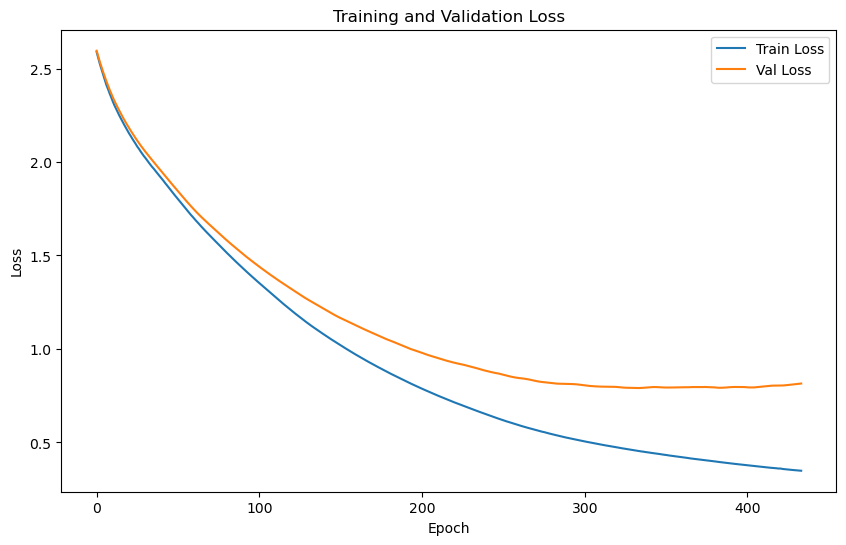

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8514 | Test Accuracy: 74.23%


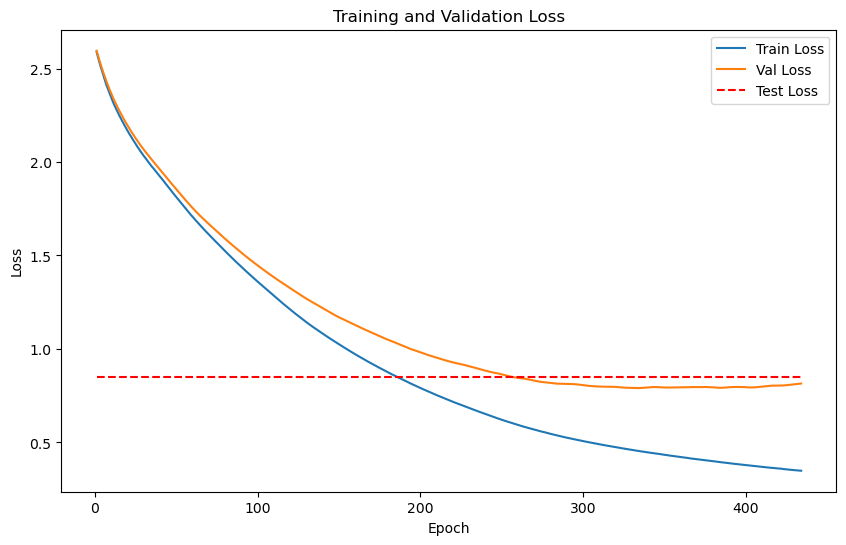

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [1/2000] - Validation


    Batch [1/1], Val Loss: 0.4734
Epoch [1/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4734

Validation loss improved from inf to 0.4734. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4706
Epoch [2/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4706

Validation loss improved from 0.4734 to 0.4706. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4672
Epoch [3/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4672

Validation loss improved from 0.4706 to 0.4672. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4637
Epoch [4/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4637

Validation loss improved from 0.4672 to 0.4637. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4599
Epoch [5/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4599

Validation loss improved from 0.4637 to 0.4599. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4560
Epoch [6/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4560

Validation loss improved from 0.4599 to 0.4560. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4522
Epoch [7/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4522

Validation loss improved from 0.4560 to 0.4522. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4486
Epoch [8/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4486

Validation loss improved from 0.4522 to 0.4486. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4457
Epoch [9/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4457

Validation loss improved from 0.4486 to 0.4457. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4435
Epoch [10/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4435

Validation loss improved from 0.4457 to 0.4435. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4416
Epoch [11/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4416

Validation loss improved from 0.4435 to 0.4416. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.4403
Epoch [12/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4403

Validation loss improved from 0.4416 to 0.4403. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4391
Epoch [13/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.4391

Validation loss improved from 0.4403 to 0.4391. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4381
Epoch [14/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4381

Validation loss improved from 0.4391 to 0.4381. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4371
Epoch [15/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4371

Validation loss improved from 0.4381 to 0.4371. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4363
Epoch [16/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4363

Validation loss improved from 0.4371 to 0.4363. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4357
Epoch [17/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4357

Validation loss improved from 0.4363 to 0.4357. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4349
Epoch [18/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4349

Validation loss improved from 0.4357 to 0.4349. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4341
Epoch [19/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4341

Validation loss improved from 0.4349 to 0.4341. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4334
Epoch [20/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4334

Validation loss improved from 0.4341 to 0.4334. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.4328
Epoch [21/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4328

Validation loss improved from 0.4334 to 0.4328. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4322
Epoch [22/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4322

Validation loss improved from 0.4328 to 0.4322. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4317
Epoch [23/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4317

Validation loss improved from 0.4322 to 0.4317. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4311
Epoch [24/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4311

Validation loss improved from 0.4317 to 0.4311. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.4305
Epoch [25/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4305

Validation loss improved from 0.4311 to 0.4305. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4299
Epoch [26/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.4299

Validation loss improved from 0.4305 to 0.4299. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.4293
Epoch [27/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.4293

Validation loss improved from 0.4299 to 0.4293. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4287
Epoch [28/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4287

Validation loss improved from 0.4293 to 0.4287. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4281
Epoch [29/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.4281

Validation loss improved from 0.4287 to 0.4281. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4274
Epoch [30/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.4274

Validation loss improved from 0.4281 to 0.4274. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4268
Epoch [31/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4268

Validation loss improved from 0.4274 to 0.4268. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4262
Epoch [32/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4262

Validation loss improved from 0.4268 to 0.4262. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4255
Epoch [33/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4255

Validation loss improved from 0.4262 to 0.4255. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4249
Epoch [34/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4249

Validation loss improved from 0.4255 to 0.4249. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4242
Epoch [35/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4242

Validation loss improved from 0.4249 to 0.4242. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4235
Epoch [36/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.4235

Validation loss improved from 0.4242 to 0.4235. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4229
Epoch [37/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.4229

Validation loss improved from 0.4235 to 0.4229. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4222
Epoch [38/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.4222

Validation loss improved from 0.4229 to 0.4222. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.4215
Epoch [39/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.4215

Validation loss improved from 0.4222 to 0.4215. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4209
Epoch [40/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.4209

Validation loss improved from 0.4215 to 0.4209. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4202
Epoch [41/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.4202

Validation loss improved from 0.4209 to 0.4202. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4195
Epoch [42/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.4195

Validation loss improved from 0.4202 to 0.4195. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4188
Epoch [43/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.4188

Validation loss improved from 0.4195 to 0.4188. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4182
Epoch [44/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.4182

Validation loss improved from 0.4188 to 0.4182. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4175
Epoch [45/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.4175

Validation loss improved from 0.4182 to 0.4175. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4168
Epoch [46/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.4168

Validation loss improved from 0.4175 to 0.4168. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4162
Epoch [47/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.4162

Validation loss improved from 0.4168 to 0.4162. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.4156
Epoch [48/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.4156

Validation loss improved from 0.4162 to 0.4156. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.4150
Epoch [49/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.4150

Validation loss improved from 0.4156 to 0.4150. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [50/2000] - Validation


    Batch [1/1], Val Loss: 0.4144
Epoch [50/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.4144

Validation loss improved from 0.4150 to 0.4144. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4138
Epoch [51/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4138

Validation loss improved from 0.4144 to 0.4138. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.4133
Epoch [52/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.4133

Validation loss improved from 0.4138 to 0.4133. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4127
Epoch [53/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.4127

Validation loss improved from 0.4133 to 0.4127. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4121
Epoch [54/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.4121

Validation loss improved from 0.4127 to 0.4121. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4115
Epoch [55/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.4115

Validation loss improved from 0.4121 to 0.4115. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4110
Epoch [56/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.4110

Validation loss improved from 0.4115 to 0.4110. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4104
Epoch [57/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.4104

Validation loss improved from 0.4110 to 0.4104. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4099
Epoch [58/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.4099

Validation loss improved from 0.4104 to 0.4099. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.4094
Epoch [59/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.4094

Validation loss improved from 0.4099 to 0.4094. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [60/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.4089

Validation loss improved from 0.4094 to 0.4089. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.4084
Epoch [61/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.4084

Validation loss improved from 0.4089 to 0.4084. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4079
Epoch [62/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.4079

Validation loss improved from 0.4084 to 0.4079. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [63/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.4075

Validation loss improved from 0.4079 to 0.4075. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4070
Epoch [64/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.4070

Validation loss improved from 0.4075 to 0.4070. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [65/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.4065

Validation loss improved from 0.4070 to 0.4065. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.4061
Epoch [66/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.4061

Validation loss improved from 0.4065 to 0.4061. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [67/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.4057

Validation loss improved from 0.4061 to 0.4057. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4052
Epoch [68/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.4052

Validation loss improved from 0.4057 to 0.4052. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4048
Epoch [69/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.4048

Validation loss improved from 0.4052 to 0.4048. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4044
Epoch [70/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.4044

Validation loss improved from 0.4048 to 0.4044. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4040
Epoch [71/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.4040

Validation loss improved from 0.4044 to 0.4040. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [72/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.4036

Validation loss improved from 0.4040 to 0.4036. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.4033
Epoch [73/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.4033

Validation loss improved from 0.4036 to 0.4033. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [74/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.4029

Validation loss improved from 0.4033 to 0.4029. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [75/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.4026

Validation loss improved from 0.4029 to 0.4026. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.4022
Epoch [76/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.4022

Validation loss improved from 0.4026 to 0.4022. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4019
Epoch [77/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.4019

Validation loss improved from 0.4022 to 0.4019. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.4015
Epoch [78/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.4015

Validation loss improved from 0.4019 to 0.4015. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4012
Epoch [79/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.4012

Validation loss improved from 0.4015 to 0.4012. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.4009
Epoch [80/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.4009

Validation loss improved from 0.4012 to 0.4009. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [81/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.4006

Validation loss improved from 0.4009 to 0.4006. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [82/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.4002

Validation loss improved from 0.4006 to 0.4002. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3999
Epoch [83/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3999

Validation loss improved from 0.4002 to 0.3999. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3996
Epoch [84/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3996

Validation loss improved from 0.3999 to 0.3996. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3992
Epoch [85/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3992

Validation loss improved from 0.3996 to 0.3992. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3989
Epoch [86/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3989

Validation loss improved from 0.3992 to 0.3989. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.3985
Epoch [87/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3985

Validation loss improved from 0.3989 to 0.3985. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [88/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3982

Validation loss improved from 0.3985 to 0.3982. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [89/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3979

Validation loss improved from 0.3982 to 0.3979. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [90/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3975

Validation loss improved from 0.3979 to 0.3975. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [91/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3972

Validation loss improved from 0.3975 to 0.3972. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [92/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3968

Validation loss improved from 0.3972 to 0.3968. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [93/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3965

Validation loss improved from 0.3968 to 0.3965. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [94/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3962

Validation loss improved from 0.3965 to 0.3962. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [95/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3958

Validation loss improved from 0.3962 to 0.3958. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [96/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3954

Validation loss improved from 0.3958 to 0.3954. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [97/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3951

Validation loss improved from 0.3954 to 0.3951. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.3948
Epoch [98/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3948

Validation loss improved from 0.3951 to 0.3948. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [99/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3944

Validation loss improved from 0.3948 to 0.3944. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3941
Epoch [100/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3941

Validation loss improved from 0.3944 to 0.3941. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [101/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3938

Validation loss improved from 0.3941 to 0.3938. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.3935
Epoch [102/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3935

Validation loss improved from 0.3938 to 0.3935. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [103/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3931

Validation loss improved from 0.3935 to 0.3931. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3928
Epoch [104/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3928

Validation loss improved from 0.3931 to 0.3928. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [105/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3925

Validation loss improved from 0.3928 to 0.3925. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [106/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3922

Validation loss improved from 0.3925 to 0.3922. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [107/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3918

Validation loss improved from 0.3922 to 0.3918. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [108/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.3911
Epoch [109/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3911

Validation loss improved from 0.3915 to 0.3911. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [110/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3908

Validation loss improved from 0.3911 to 0.3908. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [111/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3905

Validation loss improved from 0.3908 to 0.3905. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [112/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3902

Validation loss improved from 0.3905 to 0.3902. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [113/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3899

Validation loss improved from 0.3902 to 0.3899. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [114/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3896

Validation loss improved from 0.3899 to 0.3896. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [115/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3893

Validation loss improved from 0.3896 to 0.3893. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.3891
Epoch [116/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3891

Validation loss improved from 0.3893 to 0.3891. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [117/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3888

Validation loss improved from 0.3891 to 0.3888. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.3886
Epoch [118/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3886

Validation loss improved from 0.3888 to 0.3886. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [119/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3883

Validation loss improved from 0.3886 to 0.3883. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [120/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3880

Validation loss improved from 0.3883 to 0.3880. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [121/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3878

Validation loss improved from 0.3880 to 0.3878. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [122/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3875

Validation loss improved from 0.3878 to 0.3875. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3872
Epoch [123/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3872

Validation loss improved from 0.3875 to 0.3872. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3869
Epoch [124/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3869

Validation loss improved from 0.3872 to 0.3869. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3867
Epoch [125/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3867

Validation loss improved from 0.3869 to 0.3867. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [126/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3864

Validation loss improved from 0.3867 to 0.3864. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [127/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3861

Validation loss improved from 0.3864 to 0.3861. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3859
Epoch [128/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3859

Validation loss improved from 0.3861 to 0.3859. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [129/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3856

Validation loss improved from 0.3859 to 0.3856. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [130/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3854

Validation loss improved from 0.3856 to 0.3854. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [131/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3852

Validation loss improved from 0.3854 to 0.3852. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [132/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3849

Validation loss improved from 0.3852 to 0.3849. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [133/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3847

Validation loss improved from 0.3849 to 0.3847. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [134/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [135/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3843

Validation loss improved from 0.3846 to 0.3843. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [136/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [137/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3840

Validation loss improved from 0.3842 to 0.3840. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [138/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3838

Validation loss improved from 0.3840 to 0.3838. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [139/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3836

Validation loss improved from 0.3838 to 0.3836. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3834
Epoch [140/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3834

Validation loss improved from 0.3836 to 0.3834. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [141/2000] - Validation


    Batch [1/1], Val Loss: 0.3832
Epoch [141/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3832

Validation loss improved from 0.3834 to 0.3832. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3829
Epoch [142/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3829

Validation loss improved from 0.3832 to 0.3829. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3827
Epoch [143/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.3827

Validation loss improved from 0.3829 to 0.3827. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [144/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3824

Validation loss improved from 0.3827 to 0.3824. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [145/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3822

Validation loss improved from 0.3824 to 0.3822. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [146/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [147/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.3817

Validation loss improved from 0.3820 to 0.3817. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3815
Epoch [148/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3815

Validation loss improved from 0.3817 to 0.3815. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [149/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3813

Validation loss improved from 0.3815 to 0.3813. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3810
Epoch [150/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3810

Validation loss improved from 0.3813 to 0.3810. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [151/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3808

Validation loss improved from 0.3810 to 0.3808. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [152/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3806

Validation loss improved from 0.3808 to 0.3806. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3804
Epoch [153/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3804

Validation loss improved from 0.3806 to 0.3804. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [154/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3802

Validation loss improved from 0.3804 to 0.3802. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [155/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3801

Validation loss improved from 0.3802 to 0.3801. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [156/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3799

Validation loss improved from 0.3801 to 0.3799. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [157/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.3797

Validation loss improved from 0.3799 to 0.3797. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3795
Epoch [158/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3795

Validation loss improved from 0.3797 to 0.3795. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3793
Epoch [159/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3793

Validation loss improved from 0.3795 to 0.3793. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3791
Epoch [160/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3791

Validation loss improved from 0.3793 to 0.3791. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [161/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3789

Validation loss improved from 0.3791 to 0.3789. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3787
Epoch [162/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [163/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [164/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3784

Validation loss improved from 0.3786 to 0.3784. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [165/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3782

Validation loss improved from 0.3784 to 0.3782. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [166/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3780

Validation loss improved from 0.3782 to 0.3780. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3779
Epoch [167/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [168/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3777

Validation loss improved from 0.3779 to 0.3777. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3775
Epoch [169/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3775

Validation loss improved from 0.3777 to 0.3775. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [170/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.3773

Validation loss improved from 0.3775 to 0.3773. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [171/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.3772

Validation loss improved from 0.3773 to 0.3772. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [172/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3769

Validation loss improved from 0.3772 to 0.3769. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [173/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [174/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3764
Epoch [175/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [176/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [177/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [178/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3759

Validation loss improved from 0.3761 to 0.3759. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [179/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3757

Validation loss improved from 0.3759 to 0.3757. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [180/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3754
Epoch [181/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3754

Validation loss improved from 0.3756 to 0.3754. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [182/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3752

Validation loss improved from 0.3754 to 0.3752. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [183/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [184/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [185/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3748

Validation loss improved from 0.3750 to 0.3748. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [186/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [187/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3744
Epoch [188/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3744

Validation loss improved from 0.3746 to 0.3744. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [189/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3743

Validation loss improved from 0.3744 to 0.3743. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [190/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.3741

Validation loss improved from 0.3743 to 0.3741. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [191/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.3739

Validation loss improved from 0.3741 to 0.3739. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [192/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3738

Validation loss improved from 0.3739 to 0.3738. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [193/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [194/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3735

Validation loss improved from 0.3736 to 0.3735. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3734
Epoch [195/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.3734

Validation loss improved from 0.3735 to 0.3734. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [196/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3733

Validation loss improved from 0.3734 to 0.3733. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [197/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.3732

Validation loss improved from 0.3733 to 0.3732. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [198/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3730

Validation loss improved from 0.3732 to 0.3730. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3729
Epoch [199/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3729

Validation loss improved from 0.3730 to 0.3729. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [200/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3727

Validation loss improved from 0.3729 to 0.3727. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3725
Epoch [201/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3725

Validation loss improved from 0.3727 to 0.3725. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3723
Epoch [202/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3723

Validation loss improved from 0.3725 to 0.3723. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [203/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3721

Validation loss improved from 0.3723 to 0.3721. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [204/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3719

Validation loss improved from 0.3721 to 0.3719. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [205/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3717

Validation loss improved from 0.3719 to 0.3717. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3715
Epoch [206/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3715

Validation loss improved from 0.3717 to 0.3715. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [207/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3713

Validation loss improved from 0.3715 to 0.3713. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3711
Epoch [208/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3711

Validation loss improved from 0.3713 to 0.3711. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [209/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [210/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3710

Validation loss improved from 0.3710 to 0.3710. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [211/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [212/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3708
Epoch [213/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3708

Validation loss improved from 0.3708 to 0.3708. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [214/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3708

Validation loss improved from 0.3708 to 0.3708. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3708
Epoch [215/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3708

Validation loss improved from 0.3708 to 0.3708. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [216/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [217/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [218/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [219/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.3704

Validation loss improved from 0.3706 to 0.3704. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [220/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.3704

Validation loss improved from 0.3704 to 0.3704. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [221/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3703

Validation loss improved from 0.3704 to 0.3703. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [222/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3702

Validation loss improved from 0.3703 to 0.3702. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [223/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [224/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3700

Validation loss improved from 0.3701 to 0.3700. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3699
Epoch [225/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3699

Validation loss improved from 0.3700 to 0.3699. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3698
Epoch [226/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3698

Validation loss improved from 0.3699 to 0.3698. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [227/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3698

Validation loss improved from 0.3698 to 0.3698. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [228/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.3697

Validation loss improved from 0.3698 to 0.3697. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3696
Epoch [229/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3696

Validation loss improved from 0.3697 to 0.3696. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [230/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3695

Validation loss improved from 0.3696 to 0.3695. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.3694
Epoch [231/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3694

Validation loss improved from 0.3695 to 0.3694. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [232/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3693

Validation loss improved from 0.3694 to 0.3693. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [233/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3692

Validation loss improved from 0.3693 to 0.3692. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [234/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.3691

Validation loss improved from 0.3692 to 0.3691. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [235/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.3689

Validation loss improved from 0.3691 to 0.3689. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.3688
Epoch [236/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.3688

Validation loss improved from 0.3689 to 0.3688. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [237/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3686

Validation loss improved from 0.3688 to 0.3686. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [238/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [239/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3683

Validation loss improved from 0.3685 to 0.3683. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [240/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [241/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [242/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.3680

Validation loss improved from 0.3681 to 0.3680. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [243/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3679

Validation loss improved from 0.3680 to 0.3679. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [244/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3679

Validation loss improved from 0.3679 to 0.3679. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [245/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.3678

Validation loss improved from 0.3679 to 0.3678. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [246/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [247/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [248/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3677

Validation loss improved from 0.3677 to 0.3677. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [249/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [250/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.3675

Validation loss improved from 0.3676 to 0.3675. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3674
Epoch [251/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3674

Validation loss improved from 0.3675 to 0.3674. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3673
Epoch [252/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.3673

Validation loss improved from 0.3674 to 0.3673. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [253/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3672

Validation loss improved from 0.3673 to 0.3672. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [254/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3671

Validation loss improved from 0.3672 to 0.3671. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [255/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.3670

Validation loss improved from 0.3671 to 0.3670. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [256/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3669

Validation loss improved from 0.3670 to 0.3669. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [257/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3668

Validation loss improved from 0.3669 to 0.3668. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [258/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3668

Validation loss improved from 0.3668 to 0.3668. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [259/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3667

Validation loss improved from 0.3668 to 0.3667. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [260/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3667

Validation loss improved from 0.3667 to 0.3667. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [261/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3666

Validation loss improved from 0.3667 to 0.3666. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [262/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3665

Validation loss improved from 0.3666 to 0.3665. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3664
Epoch [263/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3664

Validation loss improved from 0.3665 to 0.3664. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [264/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3663

Validation loss improved from 0.3664 to 0.3663. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3662
Epoch [265/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3662

Validation loss improved from 0.3663 to 0.3662. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [266/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [267/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [268/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3660

Validation loss improved from 0.3660 to 0.3660. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [269/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [270/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3657

Validation loss improved from 0.3659 to 0.3657. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [271/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3655
Epoch [272/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.3655

Validation loss improved from 0.3656 to 0.3655. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3109
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [273/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.3653

Validation loss improved from 0.3655 to 0.3653. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [274/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3651

Validation loss improved from 0.3653 to 0.3651. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [275/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3649

Validation loss improved from 0.3651 to 0.3649. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [276/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3648

Validation loss improved from 0.3649 to 0.3648. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [277/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [278/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3645
Epoch [279/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [280/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3643
Epoch [281/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.3643

Validation loss improved from 0.3644 to 0.3643. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3643
Epoch [282/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3643

Validation loss improved from 0.3643 to 0.3643. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [283/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [284/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3641

Validation loss improved from 0.3642 to 0.3641. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [285/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.3641

Validation loss improved from 0.3641 to 0.3641. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [286/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3641

Validation loss improved from 0.3641 to 0.3641. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [287/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3641

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [288/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [289/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [290/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [291/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.3642
Epoch [292/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [293/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.3641

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [294/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3641

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [295/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3641

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [296/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3640

Validation loss improved from 0.3641 to 0.3640. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.3640
Epoch [297/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3640

Validation loss improved from 0.3640 to 0.3640. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [298/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3638

Validation loss improved from 0.3640 to 0.3638. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [299/2000] - Validation


    Batch [1/1], Val Loss: 0.3637
Epoch [299/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3637

Validation loss improved from 0.3638 to 0.3637. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [300/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.3637

Validation loss improved from 0.3637 to 0.3637. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [301/2000] - Validation


    Batch [1/1], Val Loss: 0.3636
Epoch [301/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.3636

Validation loss improved from 0.3637 to 0.3636. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [302/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3635

Validation loss improved from 0.3636 to 0.3635. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3634
Epoch [303/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3634

Validation loss improved from 0.3635 to 0.3634. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [304/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3632

Validation loss improved from 0.3634 to 0.3632. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3630
Epoch [305/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3630

Validation loss improved from 0.3632 to 0.3630. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [306/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3628

Validation loss improved from 0.3630 to 0.3628. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [307/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3625

Validation loss improved from 0.3628 to 0.3625. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [308/2000] - Validation


    Batch [1/1], Val Loss: 0.3622
Epoch [308/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3622

Validation loss improved from 0.3625 to 0.3622. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [309/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.3619

Validation loss improved from 0.3622 to 0.3619. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [310/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3617

Validation loss improved from 0.3619 to 0.3617. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [311/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3616

Validation loss improved from 0.3617 to 0.3616. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [312/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.3614
Epoch [313/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3614

Validation loss improved from 0.3615 to 0.3614. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [314/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [315/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [316/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [317/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [318/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [319/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [320/2000] - Validation


    Batch [1/1], Val Loss: 0.3615
Epoch [320/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [321/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [322/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [323/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [324/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [325/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [326/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [327/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [328/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3615
Epoch [329/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3615

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [330/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [331/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [332/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3613

Validation loss improved from 0.3614 to 0.3613. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [333/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [334/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3611

Validation loss improved from 0.3612 to 0.3611. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.3610
Epoch [335/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3610

Validation loss improved from 0.3611 to 0.3610. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [336/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.3609

Validation loss improved from 0.3610 to 0.3609. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [337/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3608

Validation loss improved from 0.3609 to 0.3608. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [338/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.3606

Validation loss improved from 0.3608 to 0.3606. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [339/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3604

Validation loss improved from 0.3606 to 0.3604. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [340/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3603

Validation loss improved from 0.3604 to 0.3603. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.3601
Epoch [341/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3601

Validation loss improved from 0.3603 to 0.3601. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [342/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3599

Validation loss improved from 0.3601 to 0.3599. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [343/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3597

Validation loss improved from 0.3599 to 0.3597. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [344/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3595

Validation loss improved from 0.3597 to 0.3595. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [345/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3593

Validation loss improved from 0.3595 to 0.3593. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [346/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3591

Validation loss improved from 0.3593 to 0.3591. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [347/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3589

Validation loss improved from 0.3591 to 0.3589. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [348/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3586

Validation loss improved from 0.3589 to 0.3586. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [349/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3584

Validation loss improved from 0.3586 to 0.3584. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [350/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3583

Validation loss improved from 0.3584 to 0.3583. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.3582
Epoch [351/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.3582

Validation loss improved from 0.3583 to 0.3582. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [352/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3580

Validation loss improved from 0.3582 to 0.3580. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [353/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3580

Validation loss improved from 0.3580 to 0.3580. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [354/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3579

Validation loss improved from 0.3580 to 0.3579. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [355/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.3578

Validation loss improved from 0.3579 to 0.3578. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [356/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3577

Validation loss improved from 0.3578 to 0.3577. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3576
Epoch [357/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.3576

Validation loss improved from 0.3577 to 0.3576. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.3574
Epoch [358/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3574

Validation loss improved from 0.3576 to 0.3574. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [359/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3573

Validation loss improved from 0.3574 to 0.3573. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [360/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.3573

Validation loss improved from 0.3573 to 0.3573. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [361/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3573

Validation loss improved from 0.3573 to 0.3573. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [362/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [363/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [364/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [365/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3572

Validation loss improved from 0.3573 to 0.3572. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [366/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.3573

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [367/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3572

Validation loss improved from 0.3572 to 0.3572. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [368/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.3572

Validation loss improved from 0.3572 to 0.3572. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [369/2000] - Validation


    Batch [1/1], Val Loss: 0.3572
Epoch [369/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.3572

Validation loss improved from 0.3572 to 0.3572. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [370/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3572

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [371/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3571

Validation loss improved from 0.3572 to 0.3571. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [372/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3571

Validation loss improved from 0.3571 to 0.3571. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [373/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.3570

Validation loss improved from 0.3571 to 0.3570. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3569
Epoch [374/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.3569

Validation loss improved from 0.3570 to 0.3569. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [375/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.3568

Validation loss improved from 0.3569 to 0.3568. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [376/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3568

Validation loss improved from 0.3568 to 0.3568. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [377/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3568

Validation loss improved from 0.3568 to 0.3568. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [378/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3567

Validation loss improved from 0.3568 to 0.3567. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [379/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [380/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.3565

Validation loss improved from 0.3566 to 0.3565. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.3563
Epoch [381/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.3563

Validation loss improved from 0.3565 to 0.3563. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [382/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3562

Validation loss improved from 0.3563 to 0.3562. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [383/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3560

Validation loss improved from 0.3562 to 0.3560. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [384/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3558

Validation loss improved from 0.3560 to 0.3558. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [385/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3556

Validation loss improved from 0.3558 to 0.3556. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [386/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3554

Validation loss improved from 0.3556 to 0.3554. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [387/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3551

Validation loss improved from 0.3554 to 0.3551. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.3549
Epoch [388/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3549

Validation loss improved from 0.3551 to 0.3549. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [389/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.3548

Validation loss improved from 0.3549 to 0.3548. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [390/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3546

Validation loss improved from 0.3548 to 0.3546. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [391/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3546

Validation loss improved from 0.3546 to 0.3546. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [392/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3545

Validation loss improved from 0.3546 to 0.3545. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [393/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [394/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3545
Epoch [395/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [396/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [397/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3545

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [398/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3545

Validation loss improved from 0.3545 to 0.3545. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3544
Epoch [399/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.3544

Validation loss improved from 0.3545 to 0.3544. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3544
Epoch [400/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3544

Validation loss improved from 0.3544 to 0.3544. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [401/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.3543

Validation loss improved from 0.3544 to 0.3543. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3542
Epoch [402/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3542

Validation loss improved from 0.3543 to 0.3542. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [403/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.3542

Validation loss improved from 0.3542 to 0.3542. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [404/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.3542

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [405/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.3542

Validation loss improved from 0.3542 to 0.3542. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [406/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.3542

Validation loss improved from 0.3542 to 0.3542. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [407/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.3540

Validation loss improved from 0.3542 to 0.3540. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [408/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3538

Validation loss improved from 0.3540 to 0.3538. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2476
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [409/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.3536

Validation loss improved from 0.3538 to 0.3536. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [410/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.3533

Validation loss improved from 0.3536 to 0.3533. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3530
Epoch [411/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3530

Validation loss improved from 0.3533 to 0.3530. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [412/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.3527

Validation loss improved from 0.3530 to 0.3527. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3524
Epoch [413/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3524

Validation loss improved from 0.3527 to 0.3524. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [414/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.3522

Validation loss improved from 0.3524 to 0.3522. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3520
Epoch [415/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3520

Validation loss improved from 0.3522 to 0.3520. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [416/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.3519

Validation loss improved from 0.3520 to 0.3519. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [417/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3518

Validation loss improved from 0.3519 to 0.3518. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [418/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [419/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.3515

Validation loss improved from 0.3517 to 0.3515. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.3514
Epoch [420/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3514

Validation loss improved from 0.3515 to 0.3514. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [421/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.3514

Validation loss improved from 0.3514 to 0.3514. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3514
Epoch [422/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.3514

Validation loss improved from 0.3514 to 0.3514. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [423/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.3513

Validation loss improved from 0.3514 to 0.3513. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.3513
Epoch [424/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3513

Validation loss improved from 0.3513 to 0.3513. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [425/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3513

Validation loss improved from 0.3513 to 0.3513. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [426/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3512

Validation loss improved from 0.3513 to 0.3512. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [427/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3512

Validation loss improved from 0.3512 to 0.3512. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [428/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3511

Validation loss improved from 0.3512 to 0.3511. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [429/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [429/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3511

Validation loss improved from 0.3511 to 0.3511. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [430/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.3510

Validation loss improved from 0.3511 to 0.3510. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3510
Epoch [431/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3510

Validation loss improved from 0.3510 to 0.3510. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [432/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3510

Validation loss improved from 0.3510 to 0.3510. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.3509
Epoch [433/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.3509

Validation loss improved from 0.3510 to 0.3509. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [434/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [435/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [436/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [437/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [437/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [438/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3511

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [439/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [440/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.3510

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [441/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.3509

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [442/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.3508

Validation loss improved from 0.3509 to 0.3508. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [443/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.3507

Validation loss improved from 0.3508 to 0.3507. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [444/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.3506

Validation loss improved from 0.3507 to 0.3506. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [445/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.3505

Validation loss improved from 0.3506 to 0.3505. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [446/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.3504

Validation loss improved from 0.3505 to 0.3504. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [447/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.3503

Validation loss improved from 0.3504 to 0.3503. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [448/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3501

Validation loss improved from 0.3503 to 0.3501. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [449/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.3499

Validation loss improved from 0.3501 to 0.3499. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [450/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3498

Validation loss improved from 0.3499 to 0.3498. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [451/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3495

Validation loss improved from 0.3498 to 0.3495. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [452/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.3494

Validation loss improved from 0.3495 to 0.3494. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [453/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3492

Validation loss improved from 0.3494 to 0.3492. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [454/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [455/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3489

Validation loss improved from 0.3490 to 0.3489. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [456/2000] - Validation


    Batch [1/1], Val Loss: 0.3487
Epoch [456/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.3487

Validation loss improved from 0.3489 to 0.3487. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [457/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3484

Validation loss improved from 0.3487 to 0.3484. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [458/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.3482

Validation loss improved from 0.3484 to 0.3482. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [459/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3480

Validation loss improved from 0.3482 to 0.3480. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3479
Epoch [460/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.3479

Validation loss improved from 0.3480 to 0.3479. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [461/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.3478

Validation loss improved from 0.3479 to 0.3478. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3476
Epoch [462/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [463/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3474

Validation loss improved from 0.3476 to 0.3474. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [464/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.3474

Validation loss improved from 0.3474 to 0.3474. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [465/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.3473

Validation loss improved from 0.3474 to 0.3473. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [466/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.3473

Validation loss improved from 0.3473 to 0.3473. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.3474
Epoch [467/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [468/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [469/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3476

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [470/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.3477

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [471/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3480
Epoch [472/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [473/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [474/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3480

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [475/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [476/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3478

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.3476
Epoch [477/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3476

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [478/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.3474

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.3472
Epoch [479/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3472

Validation loss improved from 0.3473 to 0.3472. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [480/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3470

Validation loss improved from 0.3472 to 0.3470. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [481/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3469

Validation loss improved from 0.3470 to 0.3469. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3467
Epoch [482/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.3467

Validation loss improved from 0.3469 to 0.3467. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3465
Epoch [483/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.3465

Validation loss improved from 0.3467 to 0.3465. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3464
Epoch [484/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3464

Validation loss improved from 0.3465 to 0.3464. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [485/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3463

Validation loss improved from 0.3464 to 0.3463. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.3462
Epoch [486/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.3462

Validation loss improved from 0.3463 to 0.3462. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [487/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [488/2000] - Validation


    Batch [1/1], Val Loss: 0.3464
Epoch [488/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [489/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.3464
Epoch [490/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.3464

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [491/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [492/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [493/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [494/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [495/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.3456

Validation loss improved from 0.3459 to 0.3456. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [496/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3454

Validation loss improved from 0.3456 to 0.3454. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.3452
Epoch [497/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.3452

Validation loss improved from 0.3454 to 0.3452. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [498/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3450

Validation loss improved from 0.3452 to 0.3450. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [499/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3448

Validation loss improved from 0.3450 to 0.3448. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [500/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.3447

Validation loss improved from 0.3448 to 0.3447. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [501/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.3445

Validation loss improved from 0.3447 to 0.3445. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [502/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3444

Validation loss improved from 0.3445 to 0.3444. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [503/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.3443

Validation loss improved from 0.3444 to 0.3443. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.3442
Epoch [504/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3442

Validation loss improved from 0.3443 to 0.3442. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [505/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3440

Validation loss improved from 0.3442 to 0.3440. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.3438
Epoch [506/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.3438

Validation loss improved from 0.3440 to 0.3438. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [507/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3437

Validation loss improved from 0.3438 to 0.3437. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [508/2000] - Validation


    Batch [1/1], Val Loss: 0.3436
Epoch [508/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3436

Validation loss improved from 0.3437 to 0.3436. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [509/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3435

Validation loss improved from 0.3436 to 0.3435. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [510/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3435

Validation loss improved from 0.3435 to 0.3435. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [511/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3434

Validation loss improved from 0.3435 to 0.3434. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [512/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3434

Validation loss improved from 0.3434 to 0.3434. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [513/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.3433

Validation loss improved from 0.3434 to 0.3433. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [514/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3432

Validation loss improved from 0.3433 to 0.3432. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [515/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.3431

Validation loss improved from 0.3432 to 0.3431. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [516/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.3429

Validation loss improved from 0.3431 to 0.3429. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [517/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.3427

Validation loss improved from 0.3429 to 0.3427. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [518/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3425

Validation loss improved from 0.3427 to 0.3425. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [519/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3423

Validation loss improved from 0.3425 to 0.3423. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.3422
Epoch [520/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.3422

Validation loss improved from 0.3423 to 0.3422. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [521/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.3420

Validation loss improved from 0.3422 to 0.3420. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [522/2000] - Validation


    Batch [1/1], Val Loss: 0.3419
Epoch [522/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [523/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.3418

Validation loss improved from 0.3419 to 0.3418. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.3420
Epoch [524/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [525/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [526/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [527/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [528/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.3423
Epoch [529/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [530/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [531/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [532/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [533/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [534/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [535/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [536/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [537/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.3420
Epoch [538/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [539/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3417

Validation loss improved from 0.3418 to 0.3417. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [540/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3415

Validation loss improved from 0.3417 to 0.3415. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [541/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.3412

Validation loss improved from 0.3415 to 0.3412. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [542/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3410

Validation loss improved from 0.3412 to 0.3410. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [543/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3408

Validation loss improved from 0.3410 to 0.3408. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [544/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3408

Validation loss improved from 0.3408 to 0.3408. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [545/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3407

Validation loss improved from 0.3408 to 0.3407. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [546/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3407

Validation loss improved from 0.3407 to 0.3407. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.3405
Epoch [547/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3405

Validation loss improved from 0.3407 to 0.3405. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [548/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3404

Validation loss improved from 0.3405 to 0.3404. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [549/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3403

Validation loss improved from 0.3404 to 0.3403. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [550/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3401

Validation loss improved from 0.3403 to 0.3401. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [551/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.3400

Validation loss improved from 0.3401 to 0.3400. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [552/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3399

Validation loss improved from 0.3400 to 0.3399. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [553/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.3397

Validation loss improved from 0.3399 to 0.3397. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [554/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [555/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3393

Validation loss improved from 0.3395 to 0.3393. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3391
Epoch [556/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3391

Validation loss improved from 0.3393 to 0.3391. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.3390
Epoch [557/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.3390

Validation loss improved from 0.3391 to 0.3390. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [558/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3389

Validation loss improved from 0.3390 to 0.3389. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.3389
Epoch [559/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.3389

Validation loss improved from 0.3389 to 0.3389. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [560/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3388

Validation loss improved from 0.3389 to 0.3388. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [561/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3388

Validation loss improved from 0.3388 to 0.3388. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [562/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [563/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.3386
Epoch [564/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.3386

Validation loss improved from 0.3386 to 0.3386. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [565/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [566/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [567/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.3385

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [568/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3385

Validation loss improved from 0.3385 to 0.3385. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [569/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [570/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3381

Validation loss improved from 0.3383 to 0.3381. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [571/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [572/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.3379

Validation loss improved from 0.3380 to 0.3379. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [573/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [574/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [575/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [576/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [577/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [578/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.3381
Epoch [579/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [580/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [581/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.3379

Validation loss improved from 0.3379 to 0.3379. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [582/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3378

Validation loss improved from 0.3379 to 0.3378. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [583/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3376

Validation loss improved from 0.3378 to 0.3376. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.3374
Epoch [584/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3374

Validation loss improved from 0.3376 to 0.3374. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [585/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3371

Validation loss improved from 0.3374 to 0.3371. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [586/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3368

Validation loss improved from 0.3371 to 0.3368. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [587/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3366

Validation loss improved from 0.3368 to 0.3366. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [588/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3365

Validation loss improved from 0.3366 to 0.3365. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [589/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3365

Validation loss improved from 0.3365 to 0.3365. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [590/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.3364

Validation loss improved from 0.3365 to 0.3364. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [591/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.3362

Validation loss improved from 0.3364 to 0.3362. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [592/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.3361

Validation loss improved from 0.3362 to 0.3361. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [593/2000] - Validation


    Batch [1/1], Val Loss: 0.3359
Epoch [593/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.3359

Validation loss improved from 0.3361 to 0.3359. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [594/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.3358

Validation loss improved from 0.3359 to 0.3358. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [595/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3357

Validation loss improved from 0.3358 to 0.3357. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [596/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.3357

Validation loss improved from 0.3357 to 0.3357. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [597/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [598/2000] - Validation


    Batch [1/1], Val Loss: 0.3357
Epoch [598/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.3357

Validation loss improved from 0.3357 to 0.3357. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [599/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3357

Validation loss improved from 0.3357 to 0.3357. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [600/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3356

Validation loss improved from 0.3357 to 0.3356. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [601/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [602/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [603/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.3358

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [604/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.3358
Epoch [605/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.3358

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [606/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.3358

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [607/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [608/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3355

Validation loss improved from 0.3356 to 0.3355. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.3354
Epoch [609/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [610/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.3353

Validation loss improved from 0.3354 to 0.3353. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [611/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3353

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [612/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [613/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [614/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [614/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [615/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [616/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [616/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [617/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [618/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.3352

Validation loss improved from 0.3353 to 0.3352. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [619/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.3350

Validation loss improved from 0.3352 to 0.3350. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [620/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.3349

Validation loss improved from 0.3350 to 0.3349. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.3349
Epoch [621/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3349

Validation loss improved from 0.3349 to 0.3349. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [622/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.3348

Validation loss improved from 0.3349 to 0.3348. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [623/2000] - Validation


    Batch [1/1], Val Loss: 0.3348
Epoch [623/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.3348

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [624/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [625/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [626/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [627/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [628/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.3347

Validation loss improved from 0.3348 to 0.3347. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1736
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [629/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.3345

Validation loss improved from 0.3347 to 0.3345. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [630/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.3344

Validation loss improved from 0.3345 to 0.3344. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [631/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.3343

Validation loss improved from 0.3344 to 0.3343. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1802
LOG: Epoch [632/2000] - Validation


    Batch [1/1], Val Loss: 0.3342
Epoch [632/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.3342

Validation loss improved from 0.3343 to 0.3342. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [633/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.3341

Validation loss improved from 0.3342 to 0.3341. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [634/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3340

Validation loss improved from 0.3341 to 0.3340. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [635/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.3338

Validation loss improved from 0.3340 to 0.3338. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [636/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.3338

Validation loss improved from 0.3338 to 0.3338. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [637/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.3337

Validation loss improved from 0.3338 to 0.3337. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [638/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.3336

Validation loss improved from 0.3337 to 0.3336. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [639/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3335

Validation loss improved from 0.3336 to 0.3335. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [640/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [641/2000] - Validation


    Batch [1/1], Val Loss: 0.3335
Epoch [641/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [642/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [643/2000] - Validation


    Batch [1/1], Val Loss: 0.3338
Epoch [643/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [644/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [645/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [646/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [647/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [648/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1812
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [649/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.3330

Validation loss improved from 0.3333 to 0.3330. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [650/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [651/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.3326

Validation loss improved from 0.3328 to 0.3326. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [652/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.3324

Validation loss improved from 0.3326 to 0.3324. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [653/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.3324

Validation loss improved from 0.3324 to 0.3324. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [654/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.3324

Validation loss improved from 0.3324 to 0.3324. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [655/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1660
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [656/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [657/2000] - Validation


    Batch [1/1], Val Loss: 0.3326
Epoch [657/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [658/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [659/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [660/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [661/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [662/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [663/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [664/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [665/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [666/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [666/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [667/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.3322

Validation loss improved from 0.3324 to 0.3322. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [668/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [668/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.3319

Validation loss improved from 0.3322 to 0.3319. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [669/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3317

Validation loss improved from 0.3319 to 0.3317. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [670/2000] - Validation


    Batch [1/1], Val Loss: 0.3315
Epoch [670/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.3315

Validation loss improved from 0.3317 to 0.3315. Saving model...
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [671/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.3312

Validation loss improved from 0.3315 to 0.3312. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [672/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.3311

Validation loss improved from 0.3312 to 0.3311. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [673/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3308

Validation loss improved from 0.3311 to 0.3308. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [674/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.3305
Epoch [675/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.3305

Validation loss improved from 0.3306 to 0.3305. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [676/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.3305

Validation loss improved from 0.3305 to 0.3305. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [677/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.3304

Validation loss improved from 0.3305 to 0.3304. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [678/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.3304

Validation loss improved from 0.3304 to 0.3304. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [679/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3304

Validation loss improved from 0.3304 to 0.3304. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.3303
Epoch [680/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.3303

Validation loss improved from 0.3304 to 0.3303. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [681/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.3302

Validation loss improved from 0.3303 to 0.3302. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.3303
Epoch [682/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [683/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.3303
Epoch [684/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [685/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [686/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1660
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [687/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [688/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [689/2000] - Validation


    Batch [1/1], Val Loss: 0.3304
Epoch [689/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [690/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [691/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.3302

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [692/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.3302

Validation loss improved from 0.3302 to 0.3302. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [693/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.3301

Validation loss improved from 0.3302 to 0.3301. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [694/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.3300

Validation loss improved from 0.3301 to 0.3300. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1644
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [695/2000], Avg Train Loss: 0.1644, Avg Val Loss: 0.3301

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [696/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.3302

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1530
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [697/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.3302

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.3302
Epoch [698/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.3302

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3300
Epoch [699/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.3300

Validation loss improved from 0.3300 to 0.3300. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [700/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.3297

Validation loss improved from 0.3300 to 0.3297. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [701/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.3294

Validation loss improved from 0.3297 to 0.3294. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1578
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [702/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.3291

Validation loss improved from 0.3294 to 0.3291. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [703/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.3289

Validation loss improved from 0.3291 to 0.3289. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [704/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.3287

Validation loss improved from 0.3289 to 0.3287. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [705/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.3285

Validation loss improved from 0.3287 to 0.3285. Saving model...
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [706/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [707/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [708/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.3284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [709/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.3285

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [710/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.3287

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1510
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [711/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [712/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [713/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [714/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [715/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [716/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [717/2000] - Validation


    Batch [1/1], Val Loss: 0.3293
Epoch [717/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [718/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [719/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [720/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [721/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [722/2000] - Validation


    Batch [1/1], Val Loss: 0.3293
Epoch [722/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [723/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [724/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [725/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [726/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [727/2000] - Validation


    Batch [1/1], Val Loss: 0.3292
Epoch [727/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [728/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [729/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [730/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [731/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.3291

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [732/2000] - Validation


    Batch [1/1], Val Loss: 0.3290
Epoch [732/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [733/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.3290
Epoch [734/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [735/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [736/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [736/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [737/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [738/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [738/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [739/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [740/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [741/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [742/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1538
LOG: Epoch [743/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [743/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [744/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [745/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [745/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [746/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [747/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.1537
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [748/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [749/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [750/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [751/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [752/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [753/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [754/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [754/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [755/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [756/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [757/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [758/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.3290

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [759/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [760/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [761/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [762/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [763/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [763/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [764/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [765/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [766/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [767/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [768/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [768/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [769/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [770/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [770/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [771/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [772/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [773/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [774/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [775/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [775/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [776/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [777/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [777/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [778/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [779/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [780/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [781/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [782/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.3289

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [783/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [784/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [785/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [786/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [787/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [788/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [789/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.3288
Epoch [790/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [791/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [792/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [793/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [794/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [795/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [796/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [797/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [798/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [799/2000] - Validation


    Batch [1/1], Val Loss: 0.3288
Epoch [799/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [800/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [801/2000] - Validation


    Batch [1/1], Val Loss: 0.3288
Epoch [801/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [802/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [803/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [804/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1642
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [805/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [806/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.3288

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 806!!
No improvement for 100 epochs


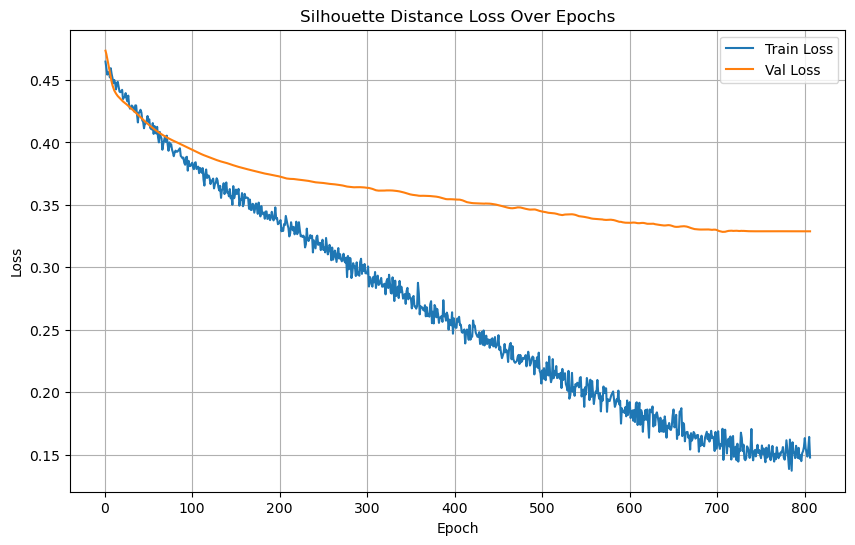

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.3015
Test Batch [20/667], Loss: 0.2391
Test Batch [30/667], Loss: 0.3527


Test Batch [40/667], Loss: 0.5109
Test Batch [50/667], Loss: 0.5341
Test Batch [60/667], Loss: 0.5279
Test Batch [70/667], Loss: 0.3595


Test Batch [80/667], Loss: 0.2201
Test Batch [90/667], Loss: 0.1179
Test Batch [100/667], Loss: 0.1908
Test Batch [110/667], Loss: 0.1665
Test Batch [120/667], Loss: 0.2598


Test Batch [130/667], Loss: 0.2896
Test Batch [140/667], Loss: 0.3090
Test Batch [150/667], Loss: 0.3287
Test Batch [160/667], Loss: 0.5000
Test Batch [170/667], Loss: 0.5000
Test Batch [180/667], Loss: 0.1819


Test Batch [190/667], Loss: 0.3699
Test Batch [200/667], Loss: 0.1879
Test Batch [210/667], Loss: 0.1634
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1546
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000


Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.3195
Test Batch [320/667], Loss: 0.1407
Test Batch [330/667], Loss: 0.2542


Test Batch [340/667], Loss: 0.2121
Test Batch [350/667], Loss: 0.1899
Test Batch [360/667], Loss: 0.1240


Test Batch [370/667], Loss: 0.1900
Test Batch [380/667], Loss: 0.1966
Test Batch [390/667], Loss: 0.1218
Test Batch [400/667], Loss: 0.1189


Test Batch [410/667], Loss: 0.1682
Test Batch [420/667], Loss: 0.2071
Test Batch [430/667], Loss: 0.1652


Test Batch [440/667], Loss: 0.3436
Test Batch [450/667], Loss: 0.2019
Test Batch [460/667], Loss: 0.3834


Test Batch [470/667], Loss: 0.3109
Test Batch [480/667], Loss: 0.3474
Test Batch [490/667], Loss: 0.3117


Test Batch [500/667], Loss: 0.3207
Test Batch [510/667], Loss: 0.1661
Test Batch [520/667], Loss: 0.2615
Test Batch [530/667], Loss: 0.2495


Test Batch [540/667], Loss: 0.2210
Test Batch [550/667], Loss: 0.3458
Test Batch [560/667], Loss: 0.2563
Test Batch [570/667], Loss: 0.2799


Test Batch [580/667], Loss: 0.2215
Test Batch [590/667], Loss: 0.2233
Test Batch [600/667], Loss: 0.3547


Test Batch [610/667], Loss: 0.3273
Test Batch [620/667], Loss: 0.3761
Test Batch [630/667], Loss: 0.3539
Test Batch [640/667], Loss: 0.1598
Test Batch [650/667], Loss: 0.3426


Test Batch [660/667], Loss: 0.4082

Test Loss: 0.3025


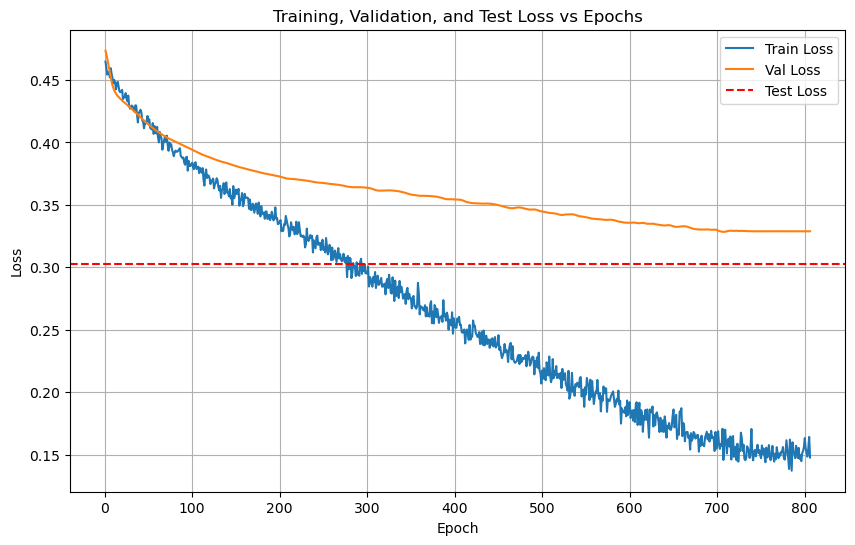

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.
  Processed batch 30/667 for test dataset.


  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.


  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.


  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.


  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.


  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.


  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.


  Processed batch 250/667 for test dataset.
  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.


  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.


  Processed batch 360/667 for test dataset.
  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.


  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.
  Processed batch 410/667 for test dataset.


  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.
  Processed batch 440/667 for test dataset.


  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.
  Processed batch 470/667 for test dataset.


  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.


  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.


  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.


  Processed batch 590/667 for test dataset.
  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.


  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.


  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.60      0.60      0.60         5
           2       0.38      0.60      0.46         5
           3       0.75      0.60      0.67         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.83      1.00      0.91         5
           7       0.67      0.40      0.50         5
           8       1.00      1.00      1.00         5

    accuracy                           0.71        45
   macro avg       0.73      0.71      0.71        45
weighted avg       0.73      0.71      0.71        45


LOG: Evaluating on the test set...
Test Accuracy: 74.67%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4317  |  Val Loss: 2.3438
Validation loss improved from inf to 2.3438.
[Epoch 2/1000] Train Loss: 2.3767  |  Val Loss: 2.3052
Validation loss improved from 2.3438 to 2.3052.
[Epoch 3/1000] Train Loss: 2.3271  |  Val Loss: 2.2678
Validation loss improved from 2.3052 to 2.2678.
[Epoch 4/1000] Train Loss: 2.2778  |  Val Loss: 2.2322
Validation loss improved from 2.2678 to 2.2322.
[Epoch 5/1000] Train Loss: 2.2317  |  Val Loss: 2.1991
Validation loss improved from 2.2322 to 2.1991.
[Epoch 6/1000] Train Loss: 2.1904  |  Val Loss: 2.1683
Validation loss improved from 2.1991 to 2.1683.
[Epoch 7/1000] Train Loss: 2.1532  |  Val Loss: 2.1390
Validation loss improved from 2.1683 to 2.1390.
[Epoch 8/1000] Train Loss: 2.1159  |  Val Loss: 2.1121
Validation loss improved from 2.1390 to 2.1121.
[Epoch 9/1000] Train Loss: 2.0839  |  Val Loss: 2.0881
Validation loss improved from 2.1121 to 2.0881.
[Epoch 10/1000] Train Loss: 2.0540  |  Val Loss: 2.0670
Validation loss impr

[Epoch 39/1000] Train Loss: 1.6095  |  Val Loss: 1.7620
Validation loss improved from 1.7687 to 1.7620.
[Epoch 40/1000] Train Loss: 1.5997  |  Val Loss: 1.7556
Validation loss improved from 1.7620 to 1.7556.
[Epoch 41/1000] Train Loss: 1.5902  |  Val Loss: 1.7492
Validation loss improved from 1.7556 to 1.7492.
[Epoch 42/1000] Train Loss: 1.5806  |  Val Loss: 1.7430
Validation loss improved from 1.7492 to 1.7430.
[Epoch 43/1000] Train Loss: 1.5713  |  Val Loss: 1.7368
Validation loss improved from 1.7430 to 1.7368.
[Epoch 44/1000] Train Loss: 1.5617  |  Val Loss: 1.7308
Validation loss improved from 1.7368 to 1.7308.
[Epoch 45/1000] Train Loss: 1.5526  |  Val Loss: 1.7249
Validation loss improved from 1.7308 to 1.7249.
[Epoch 46/1000] Train Loss: 1.5432  |  Val Loss: 1.7189
Validation loss improved from 1.7249 to 1.7189.
[Epoch 47/1000] Train Loss: 1.5340  |  Val Loss: 1.7129
Validation loss improved from 1.7189 to 1.7129.
[Epoch 48/1000] Train Loss: 1.5245  |  Val Loss: 1.7068
Validati

[Epoch 87/1000] Train Loss: 1.1906  |  Val Loss: 1.5161
Validation loss improved from 1.5198 to 1.5161.
[Epoch 88/1000] Train Loss: 1.1828  |  Val Loss: 1.5124
Validation loss improved from 1.5161 to 1.5124.
[Epoch 89/1000] Train Loss: 1.1753  |  Val Loss: 1.5088
Validation loss improved from 1.5124 to 1.5088.
[Epoch 90/1000] Train Loss: 1.1676  |  Val Loss: 1.5052
Validation loss improved from 1.5088 to 1.5052.
[Epoch 91/1000] Train Loss: 1.1600  |  Val Loss: 1.5016
Validation loss improved from 1.5052 to 1.5016.
[Epoch 92/1000] Train Loss: 1.1523  |  Val Loss: 1.4980
Validation loss improved from 1.5016 to 1.4980.
[Epoch 93/1000] Train Loss: 1.1450  |  Val Loss: 1.4944
Validation loss improved from 1.4980 to 1.4944.
[Epoch 94/1000] Train Loss: 1.1375  |  Val Loss: 1.4909
Validation loss improved from 1.4944 to 1.4909.
[Epoch 95/1000] Train Loss: 1.1299  |  Val Loss: 1.4874
Validation loss improved from 1.4909 to 1.4874.
[Epoch 96/1000] Train Loss: 1.1225  |  Val Loss: 1.4839
Validati

[Epoch 133/1000] Train Loss: 0.8338  |  Val Loss: 1.3445
Validation loss improved from 1.3484 to 1.3445.
[Epoch 134/1000] Train Loss: 0.8258  |  Val Loss: 1.3405
Validation loss improved from 1.3445 to 1.3405.
[Epoch 135/1000] Train Loss: 0.8180  |  Val Loss: 1.3364
Validation loss improved from 1.3405 to 1.3364.
[Epoch 136/1000] Train Loss: 0.8099  |  Val Loss: 1.3325
Validation loss improved from 1.3364 to 1.3325.
[Epoch 137/1000] Train Loss: 0.8019  |  Val Loss: 1.3285
Validation loss improved from 1.3325 to 1.3285.
[Epoch 138/1000] Train Loss: 0.7937  |  Val Loss: 1.3245
Validation loss improved from 1.3285 to 1.3245.
[Epoch 139/1000] Train Loss: 0.7857  |  Val Loss: 1.3205
Validation loss improved from 1.3245 to 1.3205.
[Epoch 140/1000] Train Loss: 0.7777  |  Val Loss: 1.3165
Validation loss improved from 1.3205 to 1.3165.
[Epoch 141/1000] Train Loss: 0.7696  |  Val Loss: 1.3124
Validation loss improved from 1.3165 to 1.3124.
[Epoch 142/1000] Train Loss: 0.7613  |  Val Loss: 1.308

[Epoch 175/1000] Train Loss: 0.5141  |  Val Loss: 1.1791
Validation loss improved from 1.1826 to 1.1791.
[Epoch 176/1000] Train Loss: 0.5076  |  Val Loss: 1.1757
Validation loss improved from 1.1791 to 1.1757.
[Epoch 177/1000] Train Loss: 0.5009  |  Val Loss: 1.1723
Validation loss improved from 1.1757 to 1.1723.
[Epoch 178/1000] Train Loss: 0.4944  |  Val Loss: 1.1689
Validation loss improved from 1.1723 to 1.1689.
[Epoch 179/1000] Train Loss: 0.4879  |  Val Loss: 1.1657
Validation loss improved from 1.1689 to 1.1657.
[Epoch 180/1000] Train Loss: 0.4814  |  Val Loss: 1.1624
Validation loss improved from 1.1657 to 1.1624.
[Epoch 181/1000] Train Loss: 0.4750  |  Val Loss: 1.1592
Validation loss improved from 1.1624 to 1.1592.
[Epoch 182/1000] Train Loss: 0.4687  |  Val Loss: 1.1558
Validation loss improved from 1.1592 to 1.1558.
[Epoch 183/1000] Train Loss: 0.4624  |  Val Loss: 1.1525
Validation loss improved from 1.1558 to 1.1525.
[Epoch 184/1000] Train Loss: 0.4563  |  Val Loss: 1.149

[Epoch 220/1000] Train Loss: 0.2709  |  Val Loss: 1.0639
Validation loss improved from 1.0654 to 1.0639.
[Epoch 221/1000] Train Loss: 0.2668  |  Val Loss: 1.0623
Validation loss improved from 1.0639 to 1.0623.
[Epoch 222/1000] Train Loss: 0.2630  |  Val Loss: 1.0607
Validation loss improved from 1.0623 to 1.0607.
[Epoch 223/1000] Train Loss: 0.2590  |  Val Loss: 1.0590
Validation loss improved from 1.0607 to 1.0590.
[Epoch 224/1000] Train Loss: 0.2552  |  Val Loss: 1.0575
Validation loss improved from 1.0590 to 1.0575.
[Epoch 225/1000] Train Loss: 0.2512  |  Val Loss: 1.0560
Validation loss improved from 1.0575 to 1.0560.
[Epoch 226/1000] Train Loss: 0.2476  |  Val Loss: 1.0544
Validation loss improved from 1.0560 to 1.0544.
[Epoch 227/1000] Train Loss: 0.2438  |  Val Loss: 1.0530
Validation loss improved from 1.0544 to 1.0530.
[Epoch 228/1000] Train Loss: 0.2403  |  Val Loss: 1.0515
Validation loss improved from 1.0530 to 1.0515.
[Epoch 229/1000] Train Loss: 0.2366  |  Val Loss: 1.050

[Epoch 268/1000] Train Loss: 0.1346  |  Val Loss: 1.0233
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 269/1000] Train Loss: 0.1328  |  Val Loss: 1.0235
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 270/1000] Train Loss: 0.1311  |  Val Loss: 1.0236
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 271/1000] Train Loss: 0.1293  |  Val Loss: 1.0237
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 272/1000] Train Loss: 0.1277  |  Val Loss: 1.0236
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 273/1000] Train Loss: 0.1260  |  Val Loss: 1.0236
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 274/1000] Train Loss: 0.1243  |  Val Loss: 1.0237
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 275/1000] Train Loss: 0.1227  |  Val Loss: 1.0238
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 276/1000] Train Loss: 0.1211  |  Val Loss: 1.0239
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 314/1000] Train Loss: 0.0759  |  Val Loss: 1.0353
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 315/1000] Train Loss: 0.0750  |  Val Loss: 1.0359
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 316/1000] Train Loss: 0.0742  |  Val Loss: 1.0366
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 317/1000] Train Loss: 0.0734  |  Val Loss: 1.0372
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 318/1000] Train Loss: 0.0726  |  Val Loss: 1.0377
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 319/1000] Train Loss: 0.0718  |  Val Loss: 1.0381
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 320/1000] Train Loss: 0.0710  |  Val Loss: 1.0383
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 321/1000] Train Loss: 0.0703  |  Val Loss: 1.0387
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 322/1000] Train Loss: 0.0695  |  Val Loss: 1.0389
!! Validation loss did NOT improve !! Patience:

[Epoch 361/1000] Train Loss: 0.0467  |  Val Loss: 1.0608
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 362/1000] Train Loss: 0.0463  |  Val Loss: 1.0614
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 363/1000] Train Loss: 0.0459  |  Val Loss: 1.0618
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 364/1000] Train Loss: 0.0454  |  Val Loss: 1.0622
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 365/1000] Train Loss: 0.0450  |  Val Loss: 1.0627
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 366/1000] Train Loss: 0.0446  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 366 !!
No improvement for 100 epochs.


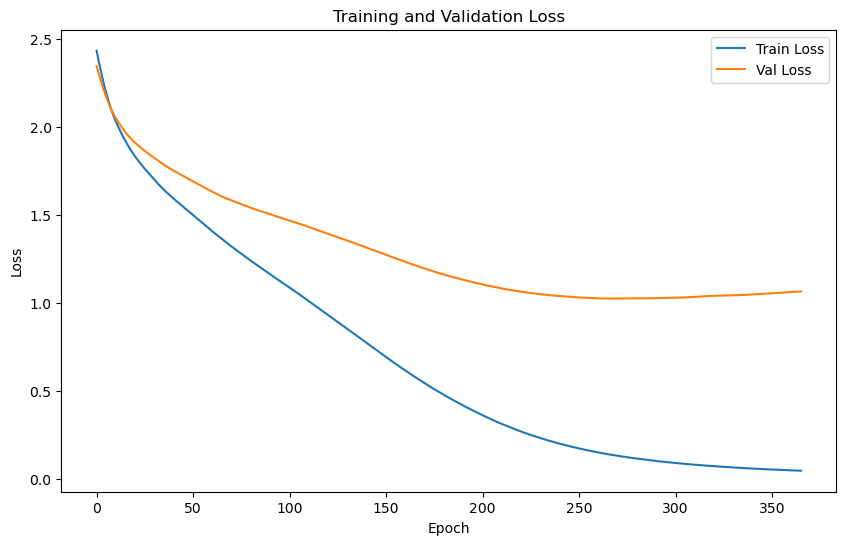

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.0104 | Test Accuracy: 74.27%


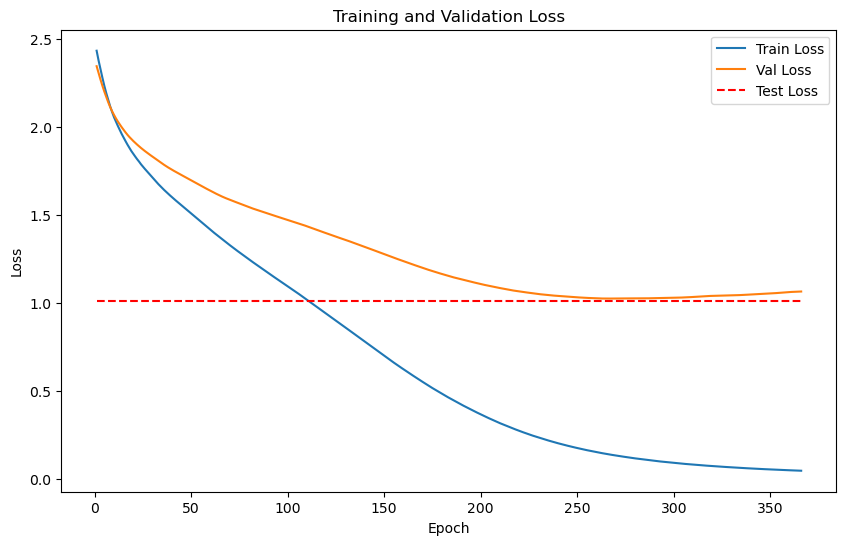

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


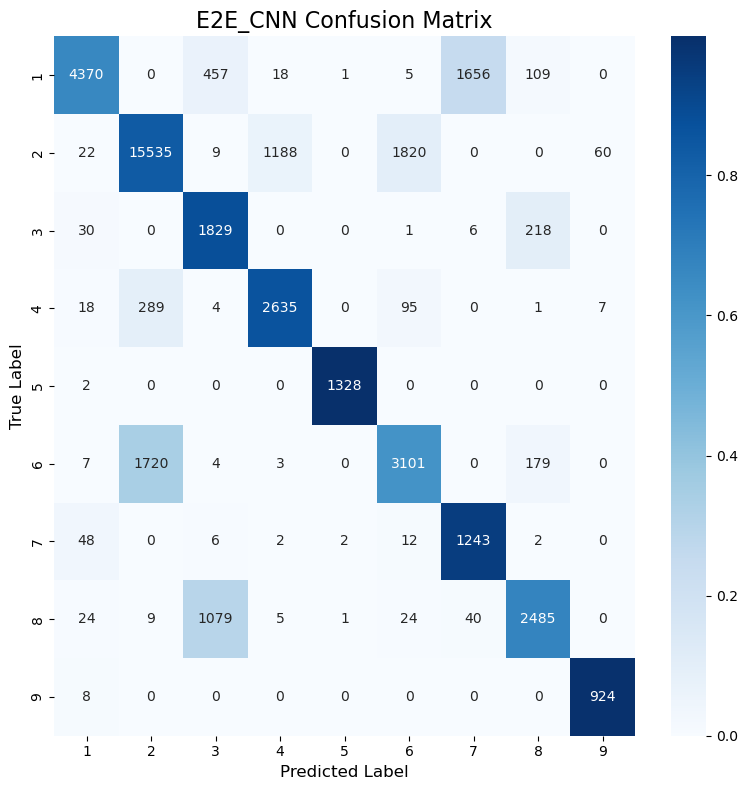

Classification Accuracy: 78.45%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


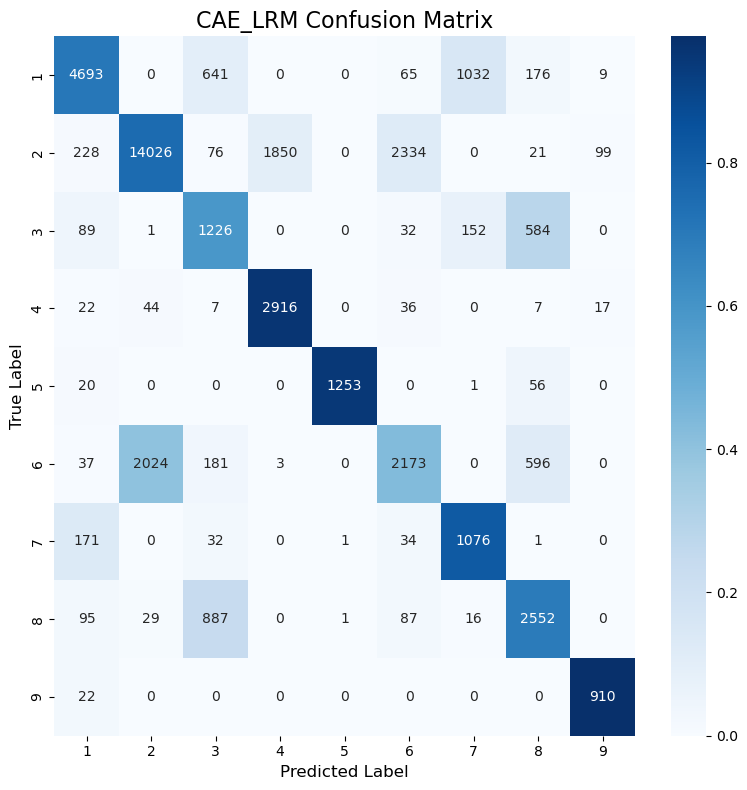

Classification Accuracy: 72.29%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


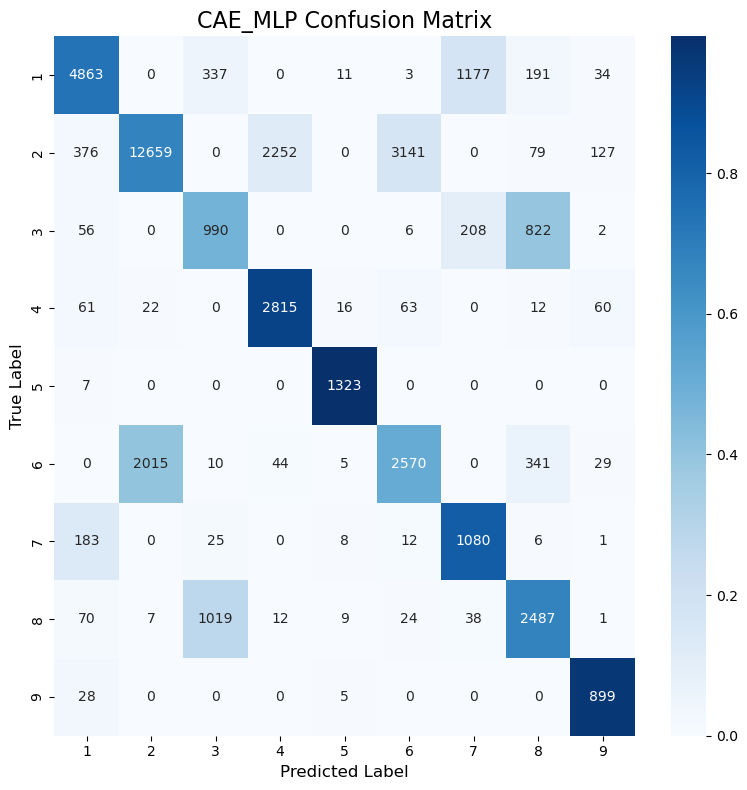

Classification Accuracy: 69.62%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


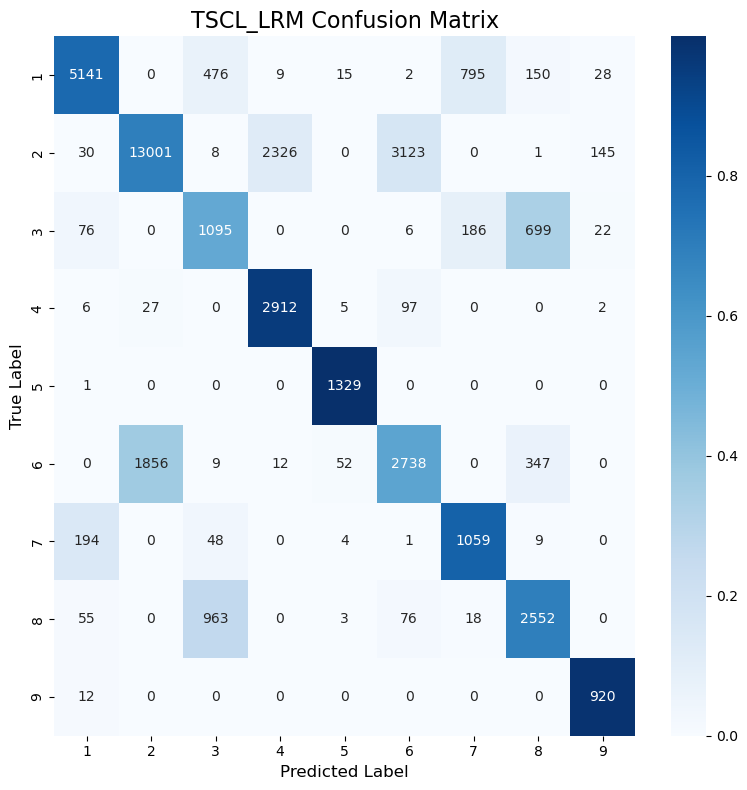

Classification Accuracy: 72.11%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


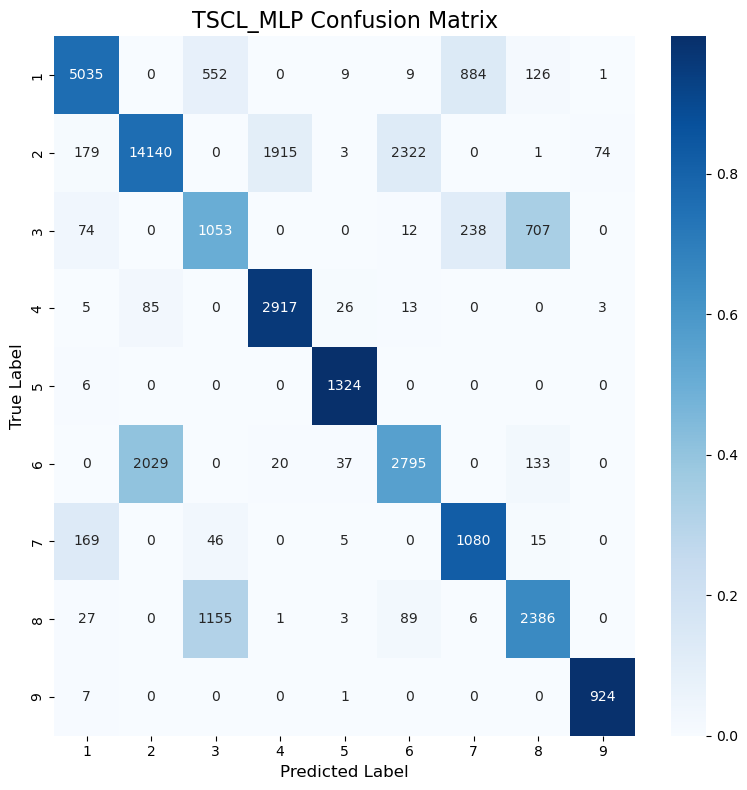

Classification Accuracy: 74.23%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


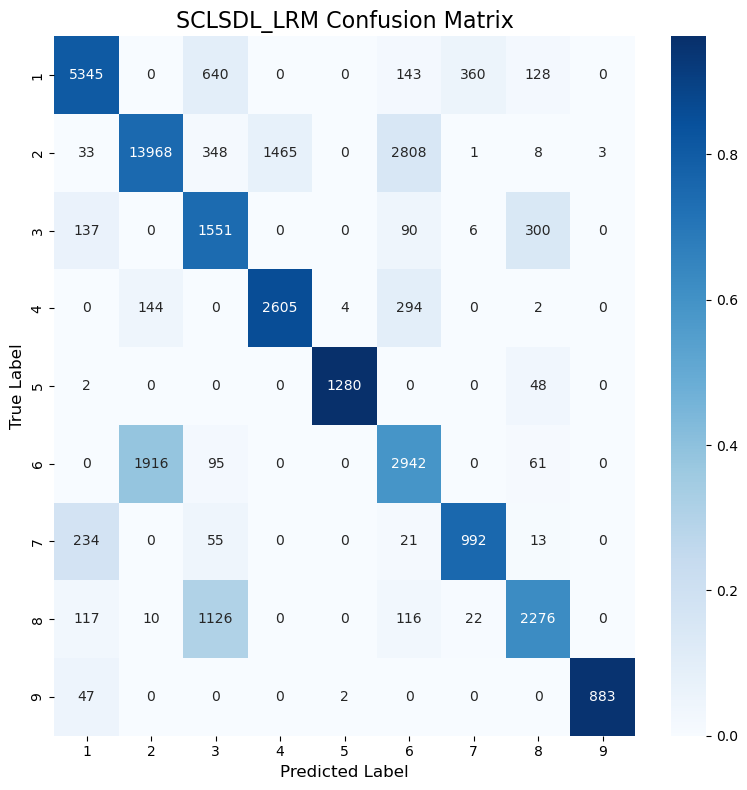

Classification Accuracy: 74.67%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


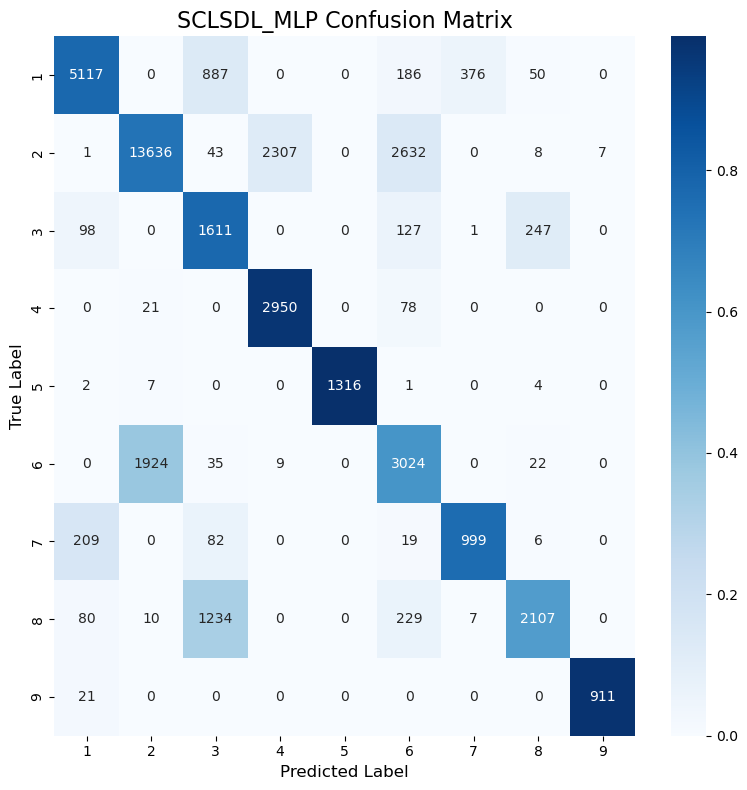

Classification Accuracy: 74.27%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          78.45
1    LRM (CAE)          72.29
2    MLP (CAE)          69.62
3     TSCL LRM          72.11
4     TSCL MLP          74.23
5  SCL_SDL LRM          74.67
6  SCL_SDL MLP          74.27

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          78.45
5  SCL_SDL LRM          74.67
6  SCL_SDL MLP          74.27
4     TSCL MLP          74.23
1    LRM (CAE)          72.29
3     TSCL LRM          72.11
2    MLP (CAE)          69.62
